In [1982]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, silhouette_score
from rfpimp import importances, plot_importances
from rfpimp import plot_corr_heatmap
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift
import warnings

%matplotlib inline
pd.set_option("display.max_columns", 2000)
pd.set_option('precision', 2) #setting the number of decimel points

In [1580]:
warnings.filterwarnings("ignore")

In [366]:
df_full=pd.read_csv('data/Seasons_Stats.csv')
df_full.drop(columns='Unnamed: 0', inplace=True)

In [367]:
df=df_full[df_full['Year']>=2005]
df.drop(labels='blank2', axis=1, inplace=True)
df.drop(labels='blanl', axis=1, inplace=True)
df['Year']=df['Year'].astype(int)
df['Year']=pd.to_datetime(df['Year'], format='%Y')
df['Year']=df['Year'].dt.year

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [369]:
def remove_tot(df_tot):
    tot_player=df_tot[df_tot['Tm']=='TOT']['Player'].values
    for name in tot_player:
        temp=df_tot[df_tot['Player']==name]
        tot_index=temp[temp['Tm']=='TOT'].index.values
        for idx in tot_index:
            year=temp.loc[idx]['Year']
            year_index=temp[temp['Year']==year].index.values
            year_temp=temp[temp['Year']==year]
            max_year=((year_temp[year_temp['Tm']!='TOT'])['G'].max())
            team=(year_temp[year_temp['G']==max_year])['Tm'].values
            team=str(team)
            team=team[1:-1]
            df_tot.at[idx,'Tm']=team
            for element in year_index:
                if element==idx:
                    continue
                else:
                    df_tot.drop(axis=0, index=element, inplace=True)
    return(df_tot)

In [370]:
df=remove_tot(df)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [371]:
df['team']=df['Tm']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [372]:
df.drop(columns='Tm',inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [373]:
df['team']=df['team'].apply(lambda x: x[1:4] if len(x)>3 else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [374]:
# dropping player with the same name:
#df[df.duplicated(subset=['Year','Player'])]
df=df.drop_duplicates(subset=['Year','Player'], keep=False)

# Selecting the features for the model:


In [375]:
#list of features I assume help predict player performance
# features used for prediction are past year data
# Features for predicting points:
    #prev_ppg
    #prev_ppm
    #prev_min
    #current age
    #prev_FG%
    #prev_FG%
    #prev_eFG% ?
    #prev_FT%
    #prev_FTA
    #prev_3P%
    #prev_3PA
    #prev_personal fouls per game
    
    
    #prev_rebound?
    #prev block?
    #prev steal?
    #prev turnover?
    
#features for predicting rebounds:
#feature for predicting assists:


    
    
# Year - Season
# Player - name
# Pos - Position
# Age - Age
# Tm - Team
# G - Games
# GS - Games Started
# MP - Minutes Played
# PER - Player Efficiency Rating
# TS% - True Shooting %
# 3PAr - 3-Point Attempt Rate
# FTr - Free Throw Rate
# ORB% - Offensive Rebound Percentage
# DRB% - Defensive Rebound Percentage
# TRB% - Total Rebound Percentage
# AST% - Assist Percentage
# STL% - Steal Percentage
# BLK% - Block Percentage
# TOV% - Turnover Percentage
# USG% - Usage Percentage

# OWS - Offensive Win Shares
# DWS - Defensive Win Shares
# WS - Win Shares
# WS/48Win Shares Per 48 Minutes

# OBPM - Offensive Box Plus/Minus
# DBPM - Defensive Box Plus/Minus
# BPM - Box Plus/Minus
# VORP - Value Over Replacement
# FG - Field Goals
# FGA - Field Goal Attempts
# FG% - Field Goal Percentage
# 3P - 3-Point Field Goals
# 3PA - 3-Point Field Goal Attempts
# 3P% - 3-Point Field Goal Percentage
# 2P - 2-Point Field Goals
# 2PA - 2-Point Field Goal Attempts
# 2P% - 2-Point Field Goal Percentage
# eFG% - Effective Field Goal Percentage
# FT - Free Throws
# FTA - Free Throw Attempts
# FT% - Free Throw Percentage
# ORB - Offensive Rebounds
# DRB - Defensive Rebounds
# TRB - Total Rebounds
# AST - Assists
# STL - Steals
# BLK - Blocks
# TOV - Turnovers
# PF - Personal Fouls
# PTS - Points

# https://www.basketball-reference.com/about/glossary.html for additional data

In [376]:
df['ppg']=df['PTS']/df['G']

In [377]:
#adding points per minute:
df['ppm']=df['PTS']/df['MP']

In [247]:
#adding variance and mean per player:

In [378]:
def mean_var(df):
    agrre=pd.DataFrame(columns=['Player','Year','ppg','mean_ppg','var_ppg'])
    player_list=df['Player'].unique()
    for element in player_list:
        temp=df[df['Player']==element][['Player','Year','ppg']]
        if temp.shape[0]==1:
            temp['mean_ppg']=temp['ppg']
            temp['var_ppg']=np.nan
        else:
            temp['mean_ppg']=temp['ppg'].expanding().mean()
            temp['var_ppg']=temp['ppg'].expanding().var()
        agrre=agrre.append(temp)
    agrre['Year']=agrre['Year'].astype(int)
    df=df.merge(agrre[['Player','Year','mean_ppg','var_ppg']],on=['Year','Player'] ,how='left')
    return(df)

In [379]:
df=mean_var(df)

In [382]:
df=df[['Year','team','Player','ppg','ppm','mean_ppg','var_ppg','PTS','Pos','Age','G','GS','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM',
 'BPM','VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']]

In [383]:
#df.at[17078,'team']='CHA'

In [471]:
(3*25.15+23.22)/4

24.667499999999997

In [475]:
df[df['Player']=='Ray Allen']['ppg_x']

927     26.44
1386    17.44
1839    18.15
2278    16.30
2723    16.51
3174    14.24
3652    10.92
4120     9.60
Name: ppg_x, dtype: float64

In [472]:
df[df['Player']=='Ray Allen']['ppg_x'].expanding().mean()

927     26.44
1386    21.94
1839    20.68
2278    19.58
2723    18.97
3174    18.18
3652    17.14
4120    16.20
Name: ppg_x, dtype: float64

In [385]:
#writing the data to a csv:
df.to_csv('data/player_2005.csv')

In [386]:
df2=df.copy()

In [103]:
df=df2.copy()

In [521]:
df3=pd.read_csv('data/player_2005.csv')

In [522]:
df3[df3['Player']=='C.J. McCollum']

Unnamed: 0  Year team         Player    ppg   ppm  mean_ppg  var_ppg  \
4406        4406  2014  POR  C.J. McCollum   5.29  0.42      5.29      NaN   
4897        4897  2015  POR  C.J. McCollum   6.84  0.44      6.06     1.20   
5370        5370  2016  POR  C.J. McCollum  20.82  0.60     10.98    73.23   
5847        5847  2017  POR  C.J. McCollum  22.96  0.66     13.98    84.69   

         PTS Pos   Age     G    GS      MP   PER   TS%  3PAr   FTr  ORB%  \
4406   201.0  SG  22.0  38.0   0.0   476.0   9.0  0.52  0.45  0.19   1.6   
4897   424.0  SG  23.0  62.0   3.0   973.0  13.1  0.53  0.38  0.20   1.6   
5370  1666.0  SG  24.0  80.0  80.0  2780.0  17.7  0.54  0.33  0.16   1.8   
5847  1837.0  SG  25.0  80.0  80.0  2796.0  19.9  0.58  0.30  0.20   2.4   

      DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  \
4406   9.2   5.4   8.7   1.5   0.3  15.4  20.9 -0.2  0.3  0.2   0.02  -2.1   
4897   8.3   5.0  10.3   2.3   0.6  10.8  20.5  0.7  1.1  1.8   0.09  -0.4   
5370   8.3   5.0  21.6   1.7   0.6  11.4  27.1  4.4  1.7  6.0   0.10   2.5   
5847   9.2   5.8  18.0   1.3   1.2   9.9  27.5  6.2  1.4  7.6   0.13   3.3   

      DBPM  BPM  VORP     FG     FGA   FG%     3P    3PA   3P%     2P     2PA  \
4406  -2.0 -4.1  -0.3   74.0   178.0  0.42   30.0   80.0  0.38   44.0    98.0   
4897  -0.3 -0.7   0.3  159.0   365.0  0.44   55.0  139.0  0.40  104.0   226.0   
5370  -2.0  0.4   1.7  641.0  1431.0  0.45  197.0  472.0  0.42  444.0   959.0   
5847  -2.2  1.0   2.1  692.0  1441.0  0.48  185.0  440.0  0.42  507.0  1001.0   

       2P%  eFG%     FT    FTA   FT%   ORB    DRB    TRB    AST   STL   BLK  \
4406  0.45  0.50   23.0   34.0  0.68   7.0   41.0   48.0   27.0  14.0   2.0   
4897  0.46  0.51   51.0   73.0  0.70  14.0   77.0   91.0   64.0  43.0   8.0   
5370  0.46  0.52  187.0  226.0  0.83  47.0  212.0  259.0  341.0  97.0  23.0   
5847  0.51  0.54  268.0  294.0  0.91  60.0  231.0  291.0  285.0  72.0  42.0   

        TOV     PF  
4406   35.0   53.0  
4897   48.0   81.0  
5370  196.0  187.0  
5847  172.0  202.0

In [387]:
# adding the previous year data
df['prev_year']=df['Year']-1

In [389]:
# merging previous year data
df=pd.merge(df,df, how='left', left_on=['prev_year','Player'], right_on=['Year','Player'])

In [405]:
df.shape

(4521, 109)

In [20]:
df.columns.shape

(105,)

In [404]:
df=df.dropna(thresh=56)

# -----------------------
## create a model for ppg

In [151]:
    #prev_ppg
    #prev_ppm
    #prev_min
    #current age
    #prev_FG%
    #prev_FG%
    #prev_eFG% ?
    #prev_FT%
    #prev_FTA
    #prev_3P%
    #prev_3PA
    #prev_personal fouls per game
    
    
    #prev_rebound?
    #prev block?
    #prev steal?
    #prev turnover?

In [403]:
df.shape

(4628, 109)

In [407]:
df['3P%_y']=df['3P%_y'].fillna(value=0)
df['FT%_y']=df['FT%_y'].fillna(value=0)
df['3P%_x']=df['3P%_x'].fillna(value=0)
df['FT%_x']=df['FT%_x'].fillna(value=0)
df['ppm_y']=df['ppm_y'].fillna(value=0)
df['MP_y']=df['MP_y'].fillna(value=0)
df['eFG%_y']=df['eFG%_y'].fillna(value=0)
df['FG%_y']=df['FG%_y'].fillna(value=0)
df['ppm_x']=df['ppm_x'].fillna(value=0)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [424]:
df=df[~df['var_ppg_y'].isna()]

In [425]:
df[df[['ppm_y','mean_ppg_y','var_ppg_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y']].isna().any(axis=1)]

Empty DataFrame
Columns: [Year_x, team_x, Player, ppg_x, ppm_x, mean_ppg_x, var_ppg_x, PTS_x, Pos_x, Age_x, G_x, GS_x, MP_x, PER_x, TS%_x, 3PAr_x, FTr_x, ORB%_x, DRB%_x, TRB%_x, AST%_x, STL%_x, BLK%_x, TOV%_x, USG%_x, OWS_x, DWS_x, WS_x, WS/48_x, OBPM_x, DBPM_x, BPM_x, VORP_x, FG_x, FGA_x, FG%_x, 3P_x, 3PA_x, 3P%_x, 2P_x, 2PA_x, 2P%_x, eFG%_x, FT_x, FTA_x, FT%_x, ORB_x, DRB_x, TRB_x, AST_x, STL_x, BLK_x, TOV_x, PF_x, prev_year_x, Year_y, team_y, ppg_y, ppm_y, mean_ppg_y, var_ppg_y, PTS_y, Pos_y, Age_y, G_y, GS_y, MP_y, PER_y, TS%_y, 3PAr_y, FTr_y, ORB%_y, DRB%_y, TRB%_y, AST%_y, STL%_y, BLK%_y, TOV%_y, USG%_y, OWS_y, DWS_y, WS_y, WS/48_y, OBPM_y, DBPM_y, BPM_y, VORP_y, FG_y, FGA_y, FG%_y, 3P_y, 3PA_y, 3P%_y, 2P_y, 2PA_y, 2P%_y, eFG%_y, FT_y, FTA_y, FT%_y, ...]
Index: []

In [428]:
df.head()

Year_x team_x               Player  ppg_x  ppm_x  mean_ppg_x  var_ppg_x  \
922    2007    SAC  Shareef Abdur-Rahim   9.91   0.39       13.02      12.34   
926    2007    CHI          Malik Allen   4.03   0.38        4.78       0.47   
927    2007    SEA            Ray Allen  26.44   0.66       25.15       1.57   
928    2007    BOS           Tony Allen  11.48   0.47        8.37       7.46   
929    2007    HOU         Rafer Alston  13.27   0.36       13.18       1.13   

      PTS_x Pos_x  Age_x   G_x  GS_x    MP_x  PER_x  TS%_x    3PAr_x  FTr_x  \
922   793.0     C   30.0  80.0  45.0  2015.0   13.1   0.52  3.10e-02   0.36   
926   242.0    PF   28.0  60.0   1.0   638.0   10.4   0.44  4.00e-03   0.13   
927  1454.0    SG   31.0  55.0  55.0  2219.0   21.6   0.56  3.84e-01   0.27   
928   379.0    SG   25.0  33.0  18.0   805.0   17.0   0.60  1.27e-01   0.52   
929  1088.0    PG   30.0  82.0  82.0  3040.0   12.9   0.50  5.19e-01   0.17   

     ORB%_x  DRB%_x  TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  USG%_x  OWS_x  \
922     7.0    16.4    11.6     9.2     1.3     1.5    13.3    19.5    1.1   
926     7.6    13.7    10.6     4.2     1.4     2.0     7.1    20.5   -0.2   
927     3.1    10.4     6.7    19.0     1.9     0.4    10.7    29.5    5.4   
928     5.1    13.6     9.2    12.5     3.2     1.2    19.1    22.1    0.8   
929     1.1     9.5     5.3    24.1     2.2     0.3    13.4    19.4    1.7   

     DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  BPM_x  VORP_x   FG_x   FGA_x  \
922    1.7   2.8     0.07    -2.1     0.0   -2.1    -0.1  310.0   654.0   
926    1.1   1.0     0.07    -4.9    -0.3   -5.2    -0.5  107.0   258.0   
927    0.9   6.3     0.14     5.4    -2.1    3.4     3.0  505.0  1153.0   
928    1.1   1.9     0.11     0.0     1.1    1.1     0.6  133.0   259.0   
929    4.9   6.6     0.10     0.4     0.9    1.3     2.5  383.0  1020.0   

     FG%_x   3P_x  3PA_x  3P%_x   2P_x  2PA_x  2P%_x  eFG%_x   FT_x  FTA_x  \
922   0.47    3.0   20.0   0.15  307.0  634.0   0.48    0.48  170.0  234.0   
926   0.41    0.0    1.0   0.00  107.0  257.0   0.42    0.41   28.0   34.0   
927   0.44  165.0  443.0   0.37  340.0  710.0   0.48    0.51  279.0  309.0   
928   0.51    8.0   33.0   0.24  125.0  226.0   0.55    0.53  105.0  134.0   
929   0.38  192.0  529.0   0.36  191.0  491.0   0.39    0.47  130.0  177.0   

     FT%_x  ORB_x  DRB_x  TRB_x  AST_x  STL_x  BLK_x  TOV_x   PF_x  \
922   0.73  122.0  276.0  398.0  109.0   53.0   40.0  116.0  243.0   
926   0.82   42.0   77.0  119.0   16.0   17.0   16.0   21.0   85.0   
927   0.90   57.0  190.0  247.0  228.0   82.0   11.0  154.0  113.0   
928   0.78   35.0   89.0  124.0   56.0   49.0   12.0   75.0   87.0   
929   0.73   29.0  253.0  282.0  444.0  129.0   10.0  170.0  195.0   

     prev_year_x  Year_y team_y  ppg_y  ppm_y  mean_ppg_y  var_ppg_y   PTS_y  \
922         2006  2006.0    SAC  12.32   0.45       14.58      10.19   887.0   
926         2006  2006.0    CHI   4.93   0.38        5.16       0.11   266.0   
927         2006  2006.0    SEA  25.06   0.65       24.50       0.64  1955.0   
928         2006  2006.0    BOS   7.24   0.38        6.81       0.36   369.0   
929         2006  2006.0    HOU  12.08   0.31       13.14       2.25   761.0   

    Pos_y  Age_y   G_y  GS_y    MP_y  PER_y  TS%_y    3PAr_y  FTr_y  ORB%_y  \
922    PF   29.0  72.0  30.0  1961.0   17.2   0.59  3.50e-02   0.44     6.4   
926    PF   27.0  54.0  20.0   701.0   11.5   0.50  4.00e-03   0.15     7.2   
927    SG   30.0  78.0  78.0  3022.0   22.2   0.59  4.35e-01   0.24     2.8   
928    PG   24.0  51.0   9.0   978.0   12.9   0.55  1.24e-01   0.49     4.1   
929    PG   29.0  63.0  63.0  2431.0   12.6   0.47  4.23e-01   0.19     1.8   

     DRB%_y  TRB%_y  AST%_y  STL%_y  BLK%_y  TOV%_y  USG%_y  OWS_y  DWS_y  \
922    14.8    10.6    13.2     1.3     1.6    12.5    20.1    4.0    2.2   
926    15.7    11.5     4.9     1.0     1.8    11.4    19.2    0.0    1.0   
927    10.6     6.6    17.2     1.8     0.4    10.2 

In [429]:
df2=df.copy()

# think for writing the DF above to CSV

In [78]:
temp=df[['ppg_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','ppg_x']]

Text(0,0.5,'variance')

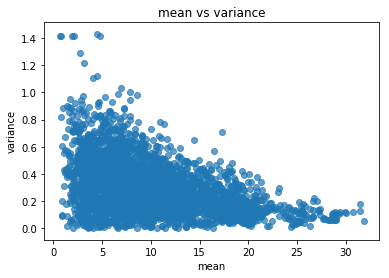

In [524]:
plt.scatter(df['mean_ppg_y'],np.sqrt(df['var_ppg_y'])/df['mean_ppg_y'], alpha =0.7)
plt.title('mean vs variance')
plt.xlabel('mean')
plt.ylabel('variance')

Text(0,0.5,'variance')

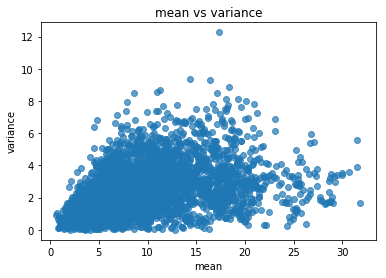

In [523]:
plt.scatter(df['mean_ppg_y'],np.sqrt(df['var_ppg_y']), alpha =0.7)
plt.title('mean vs variance')
plt.xlabel('mean')
plt.ylabel('variance')

In [135]:
# X=df[['ppg_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y']]
# y=df[['ppm_x']]
#this is for ppg

In [105]:
# X=df[['ppm_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y']]
# y=df[['ppm_x']]
# this is for ppm

In [435]:
X=df[['ppg_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','mean_ppg_y','var_ppg_y']]
y=df[['ppg_x']]
#with var and mean

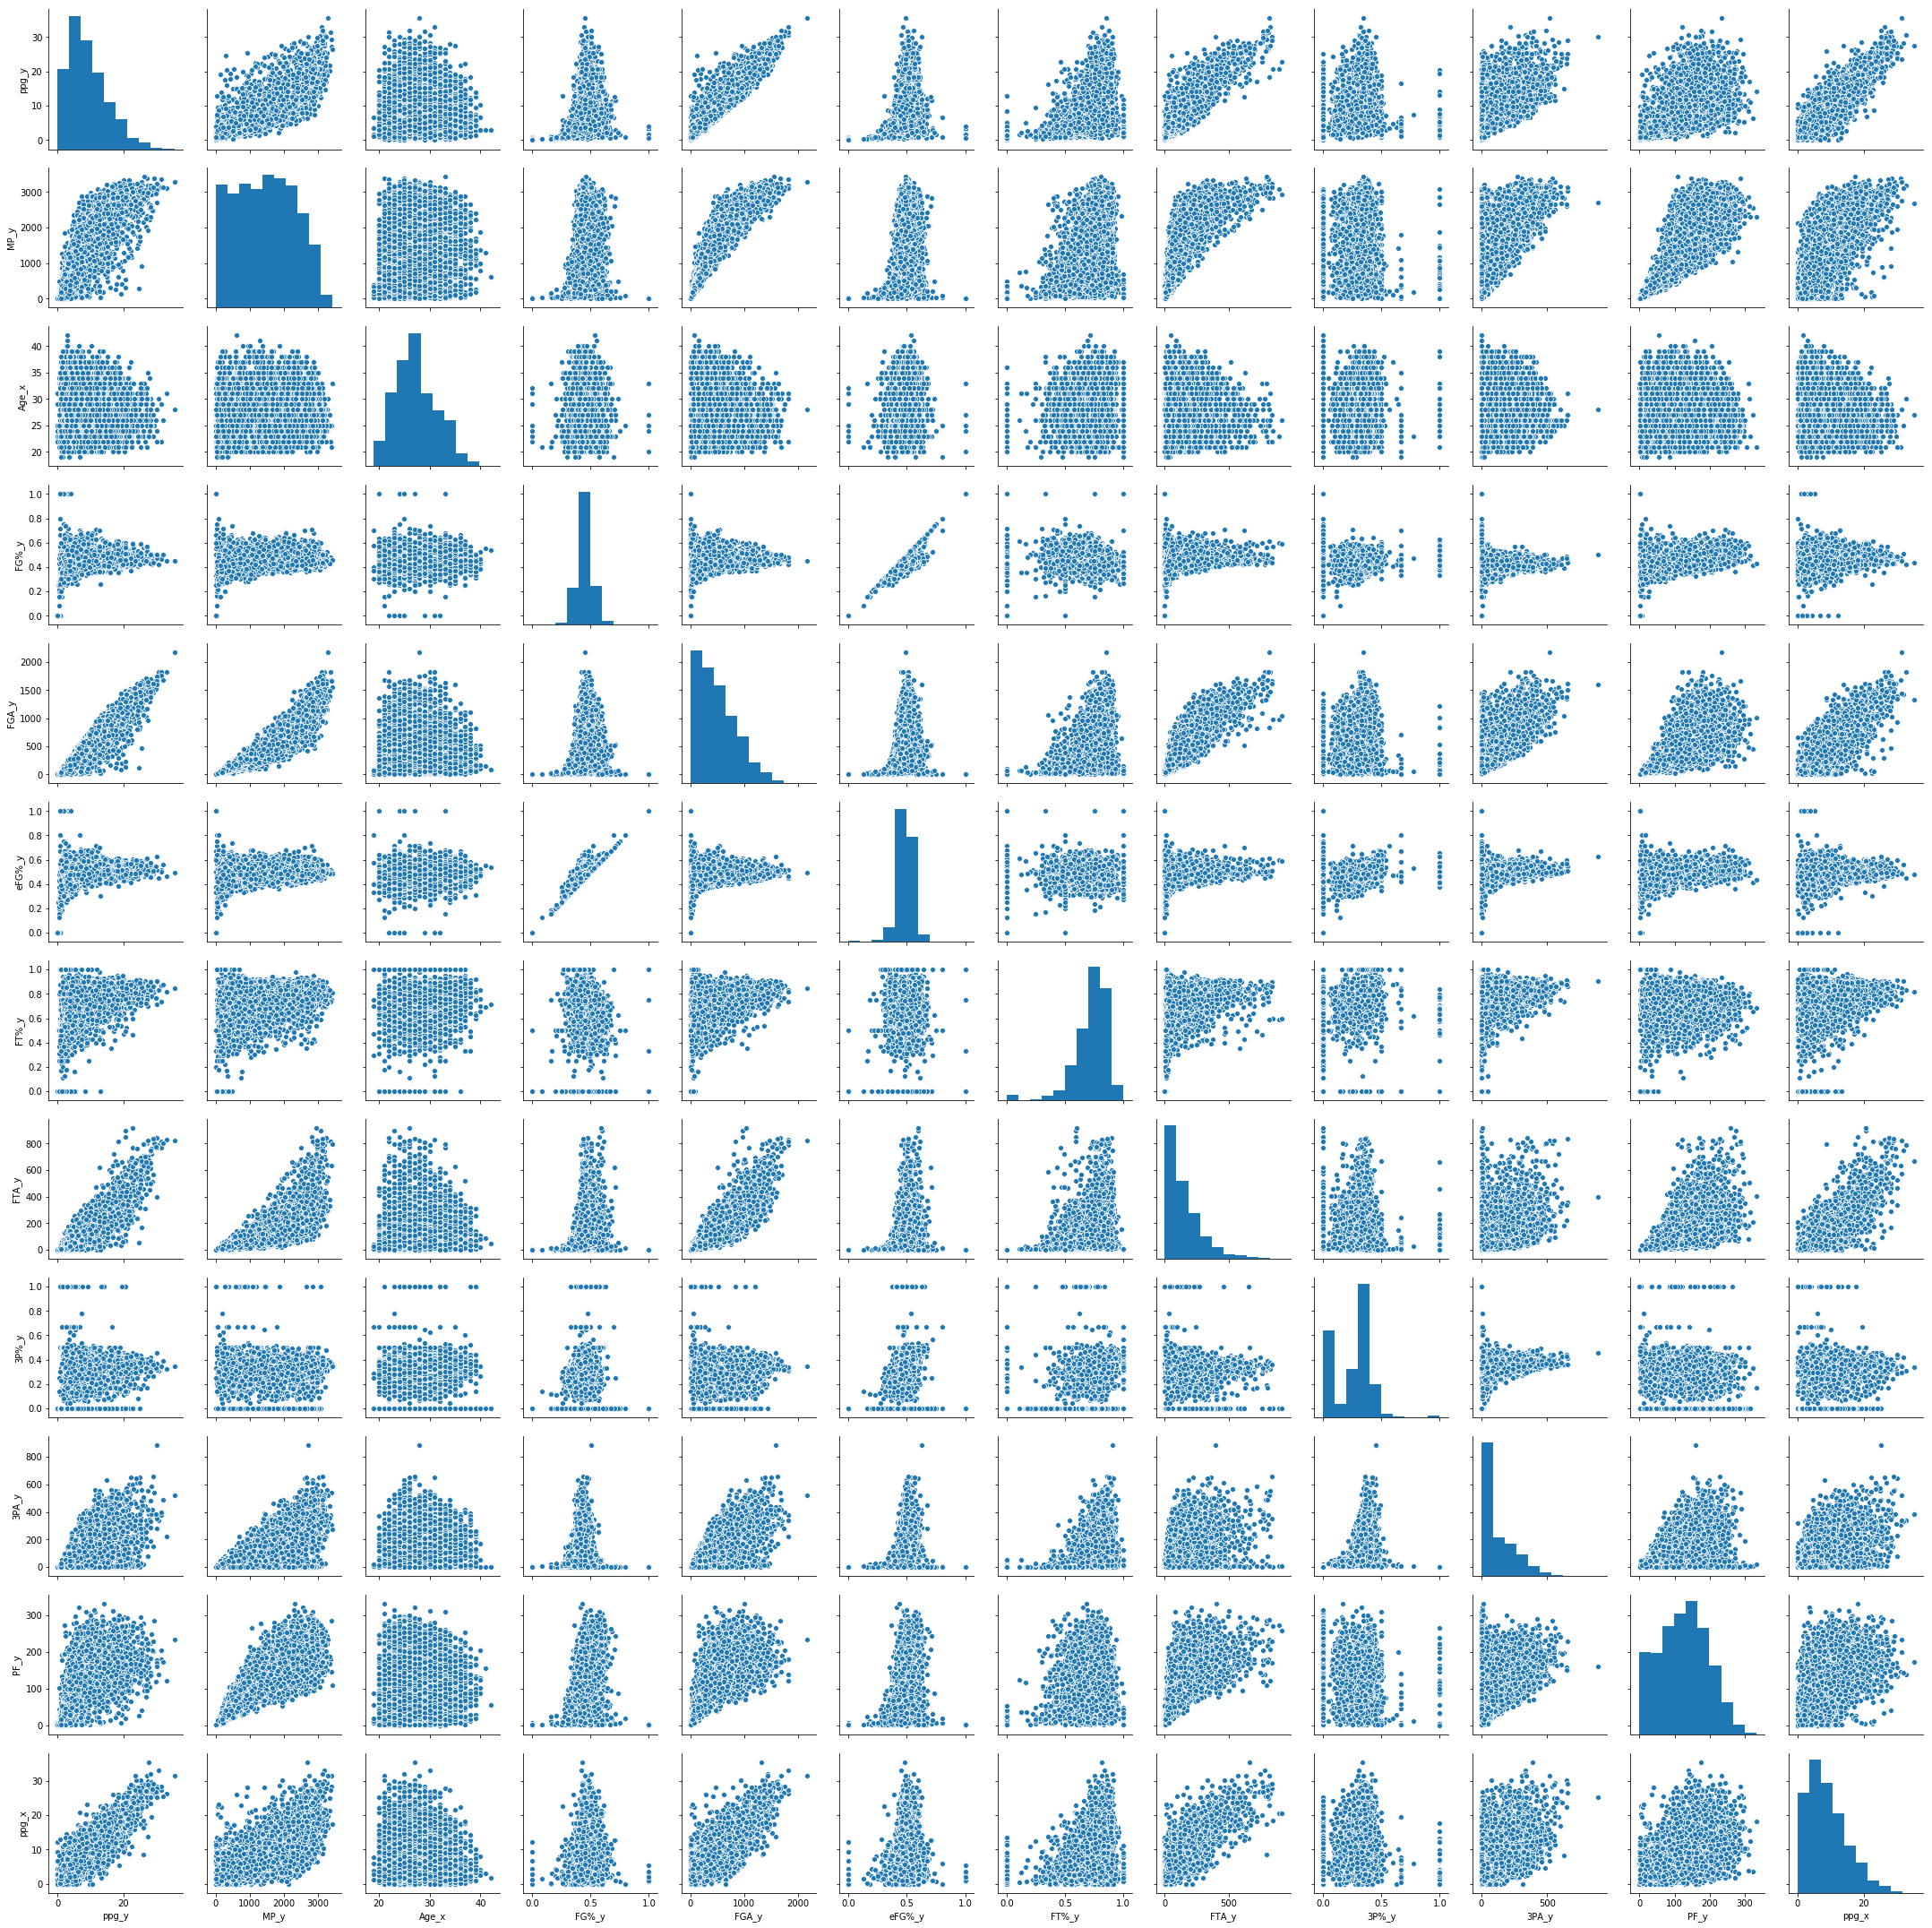

In [79]:
sns.pairplot(temp)

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [437]:
rf_reg = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)

In [438]:
rf_reg.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [439]:
y_pred=rf_reg.predict(X_test)

In [440]:
y_test.values

array([[10.47368421],
       [ 7.23076923],
       [14.47297297],
       ...,
       [ 4.63888889],
       [17.44444444],
       [ 7.19230769]])

In [441]:
y_pred.reshape(-1,1)

array([[ 9.18062816],
       [ 8.72247945],
       [16.94751246],
       ...,
       [ 8.84519154],
       [12.52213424],
       [ 8.80332754]])

Text(0,0.5,'residuals')

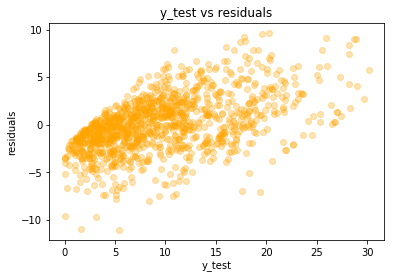

In [456]:
y_pred.reshape(-1,1)
plt.scatter(y_test.values,y_test.values-y_pred.reshape(-1,1),alpha=0.3, c='orange')
plt.title('y_test vs residuals')
plt.xlabel('y_test')
plt.ylabel('residuals')

In [443]:
mean_squared_error(y_test,y_pred)

8.743566890979888

# cross validation

In [444]:
scores=cross_validate(rf_reg,X=X_train,y=y_train,scoring='neg_mean_squared_error')

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [445]:
scores

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.84383225, 0.82203078, 0.90071106]),
 'score_time': array([0.01140094, 0.01251507, 0.01092482]),
 'test_score': array([-9.29447058, -8.47567207, -8.76032935]),
 'train_score': array([-6.48998665, -6.71969253, -6.58616524])}

In [446]:
-scores['test_score'].mean()

8.843490668809231

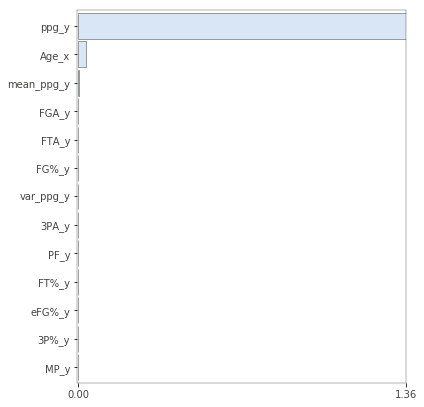

In [447]:

imp =importances(rf_reg, X_test, y_test) # permutation
viz = plot_importances(imp,width=6, vscale=2)
viz.view()

In [449]:
mean_squared_error(y_test,X_test['ppg_y'])

10.033159315161342

In [450]:
imp.values

array([[ 1.35591920e+00],
       [ 3.47332770e-02],
       [ 5.31283043e-03],
       [ 2.22682888e-03],
       [ 1.23951332e-03],
       [ 9.34743527e-04],
       [ 6.97826835e-04],
       [ 6.88376521e-04],
       [ 4.03840396e-04],
       [ 2.76973180e-04],
       [ 8.73824383e-05],
       [-1.49528973e-04],
       [-9.40847721e-04]])

In [193]:
df=df2.copy()

In [476]:
temp_2016=df[df['Year_x']==2016]

In [511]:
bins=pd.cut(temp_2016['Age_x'],5, labels=[1,2,3,4,5])

In [518]:
temp_2016[temp_2016['var_ppg_x']==73.228171176459]

Year_x team_x         Player  ppg_x  ppm_x  mean_ppg_x  var_ppg_x  \
5370    2016    POR  C.J. McCollum  20.82    0.6       10.98      73.23   

       PTS_x Pos_x  Age_x   G_x  GS_x    MP_x  PER_x  TS%_x  3PAr_x  FTr_x  \
5370  1666.0    SG   24.0  80.0  80.0  2780.0   17.7   0.54    0.33   0.16   

      ORB%_x  DRB%_x  TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  USG%_x  OWS_x  \
5370     1.8     8.3     5.0    21.6     1.7     0.6    11.4    27.1    4.4   

      DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  BPM_x  VORP_x   FG_x   FGA_x  \
5370    1.7   6.0      0.1     2.5    -2.0    0.4     1.7  641.0  1431.0   

      FG%_x   3P_x  3PA_x  3P%_x   2P_x  2PA_x  2P%_x  eFG%_x   FT_x  FTA_x  \
5370   0.45  197.0  472.0   0.42  444.0  959.0   0.46    0.52  187.0  226.0   

      FT%_x  ORB_x  DRB_x  TRB_x  AST_x  STL_x  BLK_x  TOV_x   PF_x  \
5370   0.83   47.0  212.0  259.0  341.0   97.0   23.0  196.0  187.0   

      prev_year_x  Year_y team_y  ppg_y  ppm_y  mean_ppg_y  var_ppg_y  PTS_y  \
5370         2015  2015.0    POR   6.84   0.44        6.06        1.2  424.0   

     Pos_y  Age_y   G_y  GS_y   MP_y  PER_y  TS%_y  3PAr_y  FTr_y  ORB%_y  \
5370    SG   23.0  62.0   3.0  973.0   13.1   0.53    0.38    0.2     1.6   

      DRB%_y  TRB%_y  AST%_y  STL%_y  BLK%_y  TOV%_y  USG%_y  OWS_y  DWS_y  \
5370     8.3     5.0    10.3     2.3     0.6    10.8    20.5    0.7    1.1   

      WS_y  WS/48_y  OBPM_y  DBPM_y  BPM_y  VORP_y   FG_y  FGA_y  FG%_y  3P_y  \
5370   1.8     0.09    -0.4    -0.3   -0.7     0.3  159.0  365.0   0.44  55.0   

      3PA_y  3P%_y   2P_y  2PA_y  2P%_y  eFG%_y  FT_y  FTA_y  FT%_y  ORB_y  \
5370  139.0    0.4  104.0  226.0   0.46    0.51  51.0   73.0    0.7   14.0   

      DRB_y  TRB_y  AST_y  STL_y  BLK_y  TOV_y  PF_y  prev_year_y  
5370   77.0   91.0   64.0   43.0    8.0   48.0  81.0       2014.0

In [520]:
df[df['Player']=='C.J. McCollum']

Year_x team_x         Player  ppg_x  ppm_x  mean_ppg_x  var_ppg_x  \
5370    2016    POR  C.J. McCollum  20.82   0.60       10.98      73.23   
5847    2017    POR  C.J. McCollum  22.96   0.66       13.98      84.69   

       PTS_x Pos_x  Age_x   G_x  GS_x    MP_x  PER_x  TS%_x  3PAr_x  FTr_x  \
5370  1666.0    SG   24.0  80.0  80.0  2780.0   17.7   0.54    0.33   0.16   
5847  1837.0    SG   25.0  80.0  80.0  2796.0   19.9   0.58    0.30   0.20   

      ORB%_x  DRB%_x  TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  USG%_x  OWS_x  \
5370     1.8     8.3     5.0    21.6     1.7     0.6    11.4    27.1    4.4   
5847     2.4     9.2     5.8    18.0     1.3     1.2     9.9    27.5    6.2   

      DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  BPM_x  VORP_x   FG_x   FGA_x  \
5370    1.7   6.0     0.10     2.5    -2.0    0.4     1.7  641.0  1431.0   
5847    1.4   7.6     0.13     3.3    -2.2    1.0     2.1  692.0  1441.0   

      FG%_x   3P_x  3PA_x  3P%_x   2P_x   2PA_x  2P%_x  eFG%_x   FT_x  FTA_x  \
5370   0.45  197.0  472.0   0.42  444.0   959.0   0.46    0.52  187.0  226.0   
5847   0.48  185.0  440.0   0.42  507.0  1001.0   0.51    0.54  268.0  294.0   

      FT%_x  ORB_x  DRB_x  TRB_x  AST_x  STL_x  BLK_x  TOV_x   PF_x  \
5370   0.83   47.0  212.0  259.0  341.0   97.0   23.0  196.0  187.0   
5847   0.91   60.0  231.0  291.0  285.0   72.0   42.0  172.0  202.0   

      prev_year_x  Year_y team_y  ppg_y  ppm_y  mean_ppg_y  var_ppg_y   PTS_y  \
5370         2015  2015.0    POR   6.84   0.44        6.06       1.20   424.0   
5847         2016  2016.0    POR  20.82   0.60       10.98      73.23  1666.0   

     Pos_y  Age_y   G_y  GS_y    MP_y  PER_y  TS%_y  3PAr_y  FTr_y  ORB%_y  \
5370    SG   23.0  62.0   3.0   973.0   13.1   0.53    0.38   0.20     1.6   
5847    SG   24.0  80.0  80.0  2780.0   17.7   0.54    0.33   0.16     1.8   

      DRB%_y  TRB%_y  AST%_y  STL%_y  BLK%_y  TOV%_y  USG%_y  OWS_y  DWS_y  \
5370     8.3     5.0    10.3     2.3     0.6    10.8    20.5    0.7    1.1   
5847     8.3     5.0    21.6     1.7     0.6    11.4    27.1    4.4    1.7   

      WS_y  WS/48_y  OBPM_y  DBPM_y  BPM_y  VORP_y   FG_y   FGA_y  FG%_y  \
5370   1.8     0.09    -0.4    -0.3   -0.7     0.3  159.0   365.0   0.44   
5847   6.0     0.10     2.5    -2.0    0.4     1.7  641.0  1431.0   0.45   

       3P_y  3PA_y  3P%_y   2P_y  2PA_y  2P%_y  eFG%_y   FT_y  FTA_y  FT%_y  \
5370   55.0  139.0   0.40  104.0  226.0   0.46    0.51   51.0   73.0   0.70   
5847  197.0  472.0   0.42  444.0  959.0   0.46    0.52  187.0  226.0   0.83   

      ORB_y  DRB_y  TRB_y  AST_y  STL_y  BLK_y  TOV_y   PF_y  prev_year_y  
5370   14.0   77.0   91.0   64.0   43.0    8.0   48.0   81.0       2014.0  
5847   47.0  212.0  259.0  341.0   97.0   23.0  196.0  187.0       2015.0

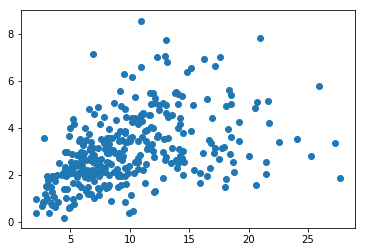

In [559]:
plt.scatter(temp_2016['mean_ppg_x'],np.sqrt(temp_2016['var_ppg_x']))

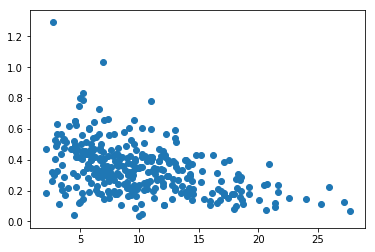

In [570]:
plt.scatter(temp_2016['mean_ppg_x'],np.sqrt(temp_2016['var_ppg_x'])/temp_2016['mean_ppg_x'])

# K-means clustering model:

In [525]:
X=temp_2016[['mean_ppg_y','var_ppg_y']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [553]:
temp_2016.sample(1)

Year_x team_x            Player  ppg_x  ppm_x  \
Brandon Jennings2016    2016    ORL  Brandon Jennings   6.92   0.38   

                      mean_ppg_x  var_ppg_x  PTS_x Pos_x  Age_x   G_x  GS_x  \
Brandon Jennings2016       15.15      15.01  332.0    PG   26.0  48.0   7.0   

                       MP_x  PER_x  TS%_x  3PAr_x  FTr_x  ORB%_x  DRB%_x  \
Brandon Jennings2016  868.0   13.7   0.49    0.51   0.26     2.0    10.4   

                      TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  USG%_x  OWS_x  \
Brandon Jennings2016     6.1    29.2     1.7     0.7    14.4    20.0    0.8   

                      DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  BPM_x  VORP_x  \
Brandon Jennings2016    0.7   1.5     0.08     0.3    -1.7   -1.4     0.1   

                       FG_x  FGA_x  FG%_x  3P_x  3PA_x  3P%_x  2P_x  2PA_x  \
Brandon Jennings2016  112.0  304.0   0.37  51.0  155.0   0.33  61.0  149.0   

                      2P%_x  eFG%_x  FT_x  FTA_x  FT%_x  ORB_x  DRB_x  TRB_x  \
Brandon Jennings2016   0.41    0.45  57.0   78.0   0.73   16.0   80.0   96.0   

                      AST_x  STL_x  BLK_x  TOV_x  PF_x  prev_year_x  Year_y  \
Brandon Jennings2016  170.0   29.0    7.0   57.0  57.0         2015  2015.0   

                     team_y  ppg_y  ppm_y  mean_ppg_y  var_ppg_y  PTS_y Pos_y  \
Brandon Jennings2016    DET  15.41   0.54       16.52       2.18  632.0    PG   

                      Age_y   G_y  GS_y    MP_y  PER_y  TS%_y  3PAr_y  FTr_y  \
Brandon Jennings2016   25.0  41.0  41.0  1173.0   19.7   0.52    0.39   0.26   

                      ORB%_y  DRB%_y  TRB%_y  AST%_y  STL%_y  BLK%_y  TOV%_y  \
Brandon Jennings2016     1.9     8.0     4.8    39.9     1.9     0.3    12.9   

                      USG%_y  OWS_y  DWS_y  WS_y  WS/48_y  OBPM_y  DBPM_y  \
Brandon Jennings2016    26.3    2.6    0.7   3.3     0.14     4.3    -2.5   

                      BPM_y  VORP_y   FG_y  FGA_y  FG%_y  3P_y  3PA_y  3P%_y  \
Brandon Jennings2016    1.8     1.1  218.0  543.0    0.4  76.0  211.0   0.36   

                       2P_y  2PA_y  2P%_y  eFG%_y   FT_y  FTA_y  FT%_y  ORB_y  \
Brandon Jennings2016  142.0  332.0   0.43    0.47  120.0  143.0   0.84   21.0   

                      DRB_y  TRB_y  AST_y  STL_y  BLK_y  TOV_y  PF_y  \
Brandon Jennings2016   83.0  104.0  272.0   44.0    4.0   90.0  64.0   

                      prev_year_y   std  
Brandon Jennings2016       2014.0  3.87

In [536]:
index=temp_2016['Player'] + temp_2016['Year_x'].astype(str)

In [537]:
temp_2016.set_index(index,inplace=True)

In [552]:
temp_2016['std']=np.sqrt(temp_2016['var_ppg_x'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [2393]:
X=temp_2016[['mean_ppg_x','std']]

In [2394]:
X=X[['log','std']]

KeyError: "['log'] not in index"

In [641]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [643]:
label=kmeans.fit_predict(X)

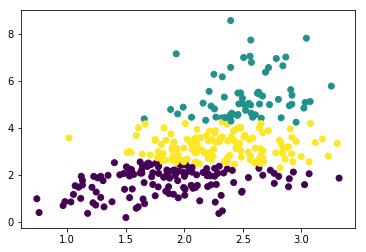

In [645]:
plt.scatter(X['log'],X['std'] ,c=label)

In [638]:
X.sort_values(by=['label'])

mean_ppg_x   std  label  label2  label3  label1   log
Quincy Acy2016                4.44  1.38      0       1       1       0  1.49
DeAndre Jordan2016            8.38  3.06      0       3       3       0  2.13
Cory Joseph2016               5.36  2.44      0       1       1       0  1.68
Sergey Karasev2016            2.91  1.54      0       1       1       0  1.07
Ryan Kelly2016                6.20  1.90      0       1       1       0  1.82
Kosta Koufos2016              5.15  2.07      0       1       1       0  1.64
Jeremy Lamb2016               6.67  2.64      0       3       3       0  1.90
Shane Larkin2016              5.40  2.35      0       1       1       0  1.69
Alex Len2016                  5.77  3.51      0       1       1       0  1.75
Meyers Leonard2016            5.56  2.43      0       1       1       0  1.72
Jon Leuer2016                 5.18  2.37      0       1       1       0  1.64
James Jones2016               5.08  2.07      0       1       1       0  1.62
Shaun Livingston2016          6.74  1.17      0       3       3       0  1.91
Shelvin Mack2016              5.94  2.06      0       1       1       0  1.78
Ian Mahinmi2016               4.81  2.02      0       1       1       0  1.57
Kendall Marshall2016          4.71  2.22      0       1       1       0  1.55
Luc Mbah2016                  6.37  2.21      0       3       3       0  1.85
Ray McCallum2016              5.65  2.09      0       1       1       0  1.73
JaVale McGee2016              7.52  2.41      0       3       3       0  2.02
Josh McRoberts2016            4.51  2.34      0       1       1       0  1.51
Patty Mills2016               7.01  2.85      0       3       3       0  1.95
Nazr Mohammed2016             4.70  2.96      0       1       1       0  1.55
E'Twaun Moore2016             5.44  2.50      0       1       1       0  1.69
Robin Lopez2016               8.22  2.94      0       3       3       0  2.11
Donatas Motiejunas2016        7.36  3.14      0       3       3       0  2.00
Dahntay Jones2016             5.76  3.45      0       1       1       0  1.75
James Johnson2016             6.52  1.86      0       3       3       0  1.87
Jimmer Fredette2016           5.07  2.55      0       1       1       0  1.62
Alonzo Gee2016                6.71  2.77      0       3       3       0  1.90
Rudy Gobert2016               6.60  3.74      0       3       3       0  1.89
...                            ...   ...    ...     ...     ...     ...   ...
Vince Carter2016             16.21  6.94      2       2       4       1  2.79
Jamal Crawford2016           16.76  2.30      2       2       4       1  2.82
Dirk Nowitzki2016            22.58  3.38      2       2       2       1  3.12
Bradley Beal2016             15.93  1.64      2       2       4       1  2.77
Joe Johnson2016              18.53  3.59      2       2       4       1  2.92
Derrick Rose2016             19.20  3.42      2       2       4       1  2.95
Stephen Curry2016            21.64  5.12      2       2       2       1  3.07
DeMarcus Cousins2016         20.50  4.84      2       2       2       1  3.02
Al Jefferson2016             16.50  5.21      2       2       4       1  2.80
LeBron James2016             27.70  1.86      2       2       2       1  3.32
Kyrie Irving2016             20.63  1.58      2       2       2       1  3.03
Zach Randolph2016            17.96  3.19      2       2       4       1  2.89
Dwight Howard2016            17.76  3.15      2       2       4       1  2.88
Brandon Knight2016           16.13  2.94      2       2       4       1  2.78
Anthony Davis2016            20.75  5.08      2       2       2       1  3.03
Paul Pierce2016              18.33  5.62      2       2       4       1  2.91
Chris Paul2016               18.75  2.12      2       2       4       1  2.93
Chris Bosh2016               20.04  2.78      2       2       4       1  3.00
Amar'e Stoudemire2016        17.58  7.01      2       2       4       1  2.87
DeMar DeRozan2016            18.12  4.94      

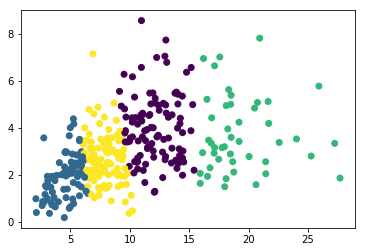

In [568]:
# kmeans2=KMeans(n_clusters=4, random_state=0)
# X['label2']=kmeans2.fit_predict(X)
plt.scatter(X['mean_ppg_x'],X['std'], c=X['label2'])

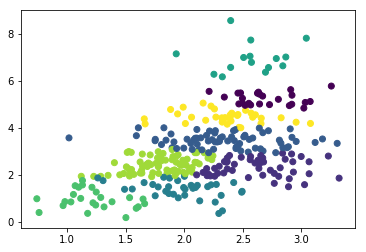

In [703]:
plt.scatter(X['log'],X['std'], c=label6)

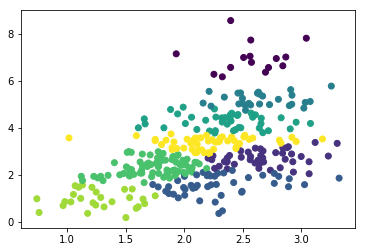

In [702]:
plt.scatter(X['log'],X['std'], c=label5)

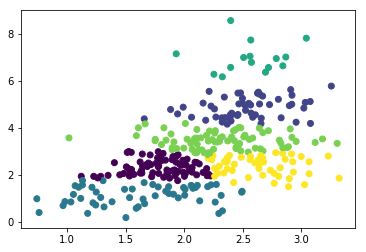

In [670]:
kmeans2=KMeans(n_clusters=6, random_state=0)
label2=kmeans2.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label2)

In [594]:
silhouette_score(X[['mean_ppg_x','std']],X['label1'])

0.5257800143492618

In [576]:
kmeans3 = KMeans(n_clusters=5, random_state=0)

In [577]:
label3=kmeans3.fit_predict(X)

In [578]:
X['label3']=label3

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


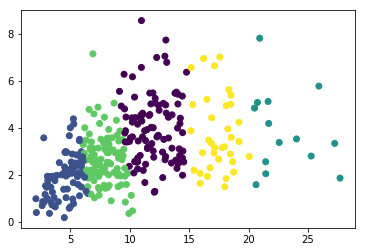

In [579]:
plt.scatter(X['mean_ppg_x'],X['std'], c=X['label3'])

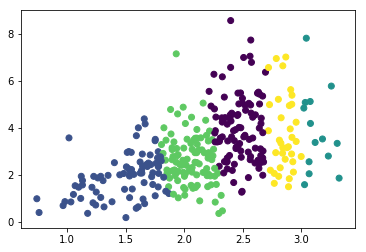

In [648]:
label3_log=kmeans3.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label3)

In [590]:
kmeans1 = KMeans(n_clusters=2, random_state=0)

In [599]:
label1=kmeans1.fit_predict(X[['mean_ppg_x','std']])

In [600]:
X['label1']=label1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


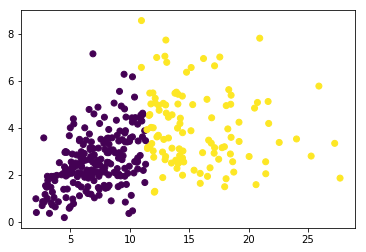

In [601]:
plt.scatter(X['mean_ppg_x'],X['std'], c=X['label1'])

In [609]:
spectral=SpectralClustering(n_clusters=8)

In [610]:
label5=spectral.fit_predict(X[['mean_ppg_x','std']])

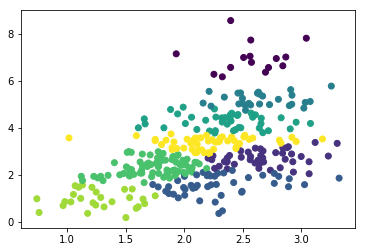

In [658]:
spectral=SpectralClustering(n_clusters=8)
label5=spectral.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label5)

In [2402]:
temp.columns

Index(['ppg_y_std', 'log_mean_ppg_y'], dtype='object')

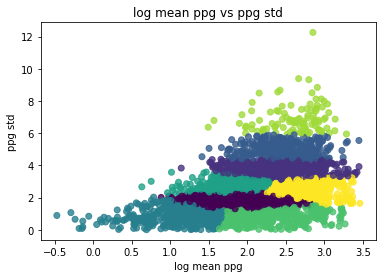

In [2416]:
mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
label=mini.fit_predict(temp)
plt.scatter(temp['log_mean_ppg_y'],temp['ppg_y_std'], c=label, alpha=0.8)
plt.title('log mean ppg vs ppg std')
plt.xlabel('log mean ppg')
plt.ylabel('ppg std')
plt.savefig('plots/KMeans_minibatch')
plt.show()

In [2391]:
mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=5)
label6=mini.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label6)

KeyError: 'log'

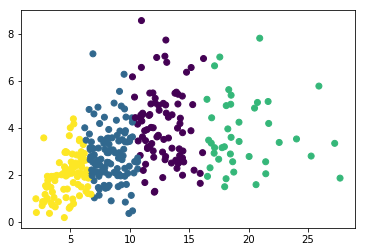

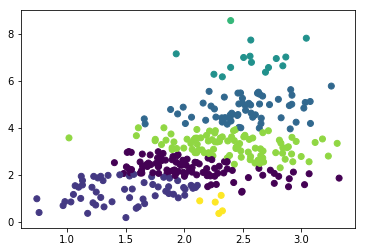

In [682]:
birch=Birch(n_clusters=7)
label7=birch.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label7)

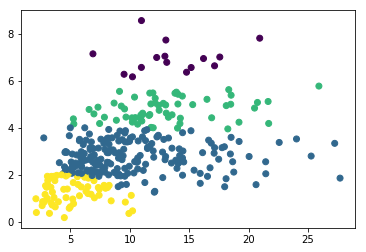

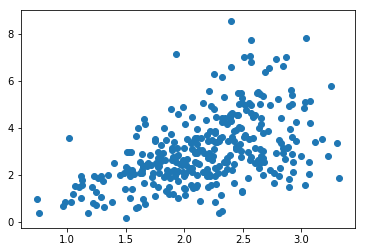

In [631]:
plt.scatter(np.log(X['mean_ppg_x']),X['std'])

In [632]:
X['log']=np.log(X['mean_ppg_x'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


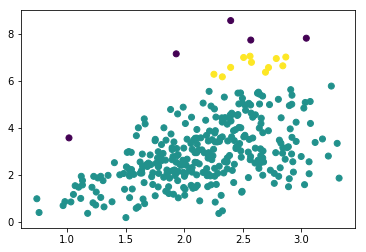

In [698]:
dbscan=DBSCAN(eps=0.5)
label_d=dbscan.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label_d)

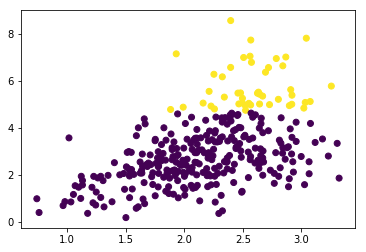

In [701]:
meanshift=MeanShift()
label_mean=meanshift.fit_predict(X)
plt.scatter(X['log'],X['std'], c=label_mean)

# Choose the minibatch clustering model!

In [749]:
# add the log mean to reduce distance between close points so cluster would work better:
df['log_mean_ppg_x']=np.log(df['mean_ppg_x'])
df['log_mean_ppg_y']=np.log(df['mean_ppg_y'])
df['ppg_x_std']=np.sqrt(df['var_ppg_x'])
df['ppg_y_std']=np.sqrt(df['var_ppg_y'])

In [750]:
# clustering players based on years 2016 and prior:
df_2016=df[df['Year_x']==2016]
index=temp_2016['Player'] + temp_2016['Year_x'].astype(str)
df_2016.set_index(index,inplace=True)

In [751]:
X=df_2016[['log_mean_ppg_x','ppg_x_std']]

In [752]:
X.head()

log_mean_ppg_x  ppg_x_std
Quincy Acy2016               1.49       1.38
Steven Adams2016             1.84       2.62
Arron Afflalo2016            2.47       5.01
Alexis Ajinca2016            1.48       2.06
Cole Aldrich2016             1.12       1.94

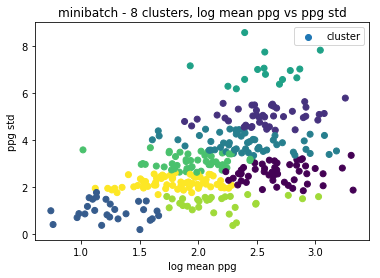

In [761]:
mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
label_m=mini.fit_predict(X)
plt.scatter(X['log_mean_ppg_x'],X['ppg_x_std'], c=label_m,label='cluster')
plt.title('minibatch - 8 clusters, log mean ppg vs ppg std')
plt.xlabel('log mean ppg')
plt.ylabel('ppg std')
plt.legend()

In [763]:
df_2016['label']=label_m

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [802]:
df_2016.shape

(335, 114)

In [776]:
df_2016.sort_values(by=['label'])[['label','mean_ppg_x','ppg_x_std']]

label  mean_ppg_x  ppg_x_std
Randy Foye2016                   0       10.88       2.82
Michael Carter-Williams2016      0       14.28       2.59
Roy Hibbert2016                  0       10.42       2.56
Chris Paul2016                   0       18.75       2.12
Chandler Parsons2016             0       14.20       2.82
Tony Parker2016                  0       17.48       2.66
Victor Oladipo2016               0       15.93       2.06
Jrue Holiday2016                 0       14.16       3.10
Jameer Nelson2016                0       12.02       2.75
Al Horford2016                   0       14.44       2.72
Jamal Crawford2016               0       16.76       2.30
Greg Monroe2016                  0       14.54       2.55
Chris Bosh2016                   0       20.04       2.78
Dwight Howard2016                0       17.76       3.15
Ersan Ilyasova2016               0       10.67       2.25
Ben McLemore2016                 0        9.58       2.28
Mike Conley2016                  0       13.51       2.50
Wesley Matthews2016              0       14.08       2.49
Marc Gasol2016                   0       14.44       1.98
Jarrett Jack2016                 0       11.33       2.45
Brook Lopez2016                  0       18.66       2.56
Darren Collison2016              0       12.78       1.88
Damian Lillard2016               0       21.44       2.55
LeBron James2016                 0       27.70       1.86
Michael Kidd-Gilchrist2016       0        9.96       2.36
Brandon Knight2016               0       16.13       2.94
Zach Randolph2016                0       17.96       3.19
Luol Deng2016                    0       15.41       2.20
Kyle Korver2016                  0       10.35       2.08
Jeff Green2016                   0       13.97       2.28
...                            ...         ...        ...
Shane Larkin2016                 7        5.40       2.35
Kosta Koufos2016                 7        5.15       2.07
Cory Joseph2016                  7        5.36       2.44
Omri Casspi2016                  7        8.21       2.52
Josh McRoberts2016               7        4.51       2.34
Norris Cole2016                  7        7.40       1.94
Nick Collison2016                7        5.94       2.38
E'Twaun Moore2016                7        5.44       2.50
Donald Sloan2016                 7        5.14       2.19
Chuck Hayes2016                  7        3.41       1.93
Kevin Seraphin2016               7        5.82       2.49
Mike Scott2016                   7        7.03       2.15
John Henson2016                  7        7.79       2.27
Robert Sacre2016                 7        3.70       1.75
Terrence Ross2016                7        9.24       1.95
Troy Daniels2016                 7        5.92       2.34
Brian Roberts2016                7        6.80       2.21
Jason Smith2016                  7        6.90       2.54
Matt Barnes2016                  7        8.10       2.53
Jerryd Bayless2016               7        8.68       2.10
Aron Baynes2016                  7        4.66       2.09
Kendrick Perkins2016             7        5.21       2.36
Anthony Bennett2016              7        3.62       1.94
Patrick Beverley2016             7        8.95       2.26
Zaza Pachulia2016                7        7.37       2.56
Steve Blake2016                  7        6.49       2.14
Steve Novak2016                  7        4.07       2.52
Matt Bonner2016                  7        5.60       1.92
Tyson Chandler2016               7        8.99       1.96
Tyler Zeller2016                 7        7.46       2.04

[335 rows x 3 columns]

In [777]:
df_index=df['Player'] + df['Year_x'].astype(str)

In [792]:
dfi.head()

Year_x team_x               Player  ppg_x  ppm_x  \
Shareef Abdur-Rahim2007    2007    SAC  Shareef Abdur-Rahim   9.91   0.39   
Malik Allen2007            2007    CHI          Malik Allen   4.03   0.38   
Ray Allen2007              2007    SEA            Ray Allen  26.44   0.66   
Tony Allen2007             2007    BOS           Tony Allen  11.48   0.47   
Rafer Alston2007           2007    HOU         Rafer Alston  13.27   0.36   

                         mean_ppg_x  var_ppg_x   PTS_x Pos_x  Age_x   G_x  \
Shareef Abdur-Rahim2007       13.02      12.34   793.0     C   30.0  80.0   
Malik Allen2007                4.78       0.47   242.0    PF   28.0  60.0   
Ray Allen2007                 25.15       1.57  1454.0    SG   31.0  55.0   
Tony Allen2007                 8.37       7.46   379.0    SG   25.0  33.0   
Rafer Alston2007              13.18       1.13  1088.0    PG   30.0  82.0   

                         GS_x    MP_x  PER_x  TS%_x    3PAr_x  FTr_x  ORB%_x  \
Shareef Abdur-Rahim2007  45.0  2015.0   13.1   0.52  3.10e-02   0.36     7.0   
Malik Allen2007           1.0   638.0   10.4   0.44  4.00e-03   0.13     7.6   
Ray Allen2007            55.0  2219.0   21.6   0.56  3.84e-01   0.27     3.1   
Tony Allen2007           18.0   805.0   17.0   0.60  1.27e-01   0.52     5.1   
Rafer Alston2007         82.0  3040.0   12.9   0.50  5.19e-01   0.17     1.1   

                         DRB%_x  TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  \
Shareef Abdur-Rahim2007    16.4    11.6     9.2     1.3     1.5    13.3   
Malik Allen2007            13.7    10.6     4.2     1.4     2.0     7.1   
Ray Allen2007              10.4     6.7    19.0     1.9     0.4    10.7   
Tony Allen2007             13.6     9.2    12.5     3.2     1.2    19.1   
Rafer Alston2007            9.5     5.3    24.1     2.2     0.3    13.4   

                         USG%_x  OWS_x  DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  \
Shareef Abdur-Rahim2007    19.5    1.1    1.7   2.8     0.07    -2.1     0.0   
Malik Allen2007            20.5   -0.2    1.1   1.0     0.07    -4.9    -0.3   
Ray Allen2007              29.5    5.4    0.9   6.3     0.14     5.4    -2.1   
Tony Allen2007             22.1    0.8    1.1   1.9     0.11     0.0     1.1   
Rafer Alston2007           19.4    1.7    4.9   6.6     0.10     0.4     0.9   

                         BPM_x  VORP_x   FG_x   FGA_x  FG%_x   3P_x  3PA_x  \
Shareef Abdur-Rahim2007   -2.1    -0.1  310.0   654.0   0.47    3.0   20.0   
Malik Allen2007           -5.2    -0.5  107.0   258.0   0.41    0.0    1.0   
Ray Allen2007              3.4     3.0  505.0  1153.0   0.44  165.0  443.0   
Tony Allen2007             1.1     0.6  133.0   259.0   0.51    8.0   33.0   
Rafer Alston2007           1.3     2.5  383.0  1020.0   0.38  192.0  529.0   

                         3P%_x   2P_x  2PA_x  2P%_x  eFG%_x   FT_x  FTA_x  \
Shareef Abdur-Rahim2007   0.15  307.0  634.0   0.48    0.48  170.0  234.0   
Malik Allen2007           0.00  107.0  257.0   0.42    0.41   28.0   34.0   
Ray Allen2007             0.37  340.0  710.0   0.48    0.51  279.0  309.0   
Tony Allen2007            0.24  125.0  226.0   0.55    0.53  105.0  134.0   
Rafer Alston2007          0.36  191.0  491.0   0.39    0.47  130.0  177.0   

                         FT%_x  ORB_x  DRB_x  TRB_x  AST_x  STL_x  BLK_x  \
Shareef Abdur-Rahim2007   0.73  122.0  276.0  398.0  109.0   53.0   40.0   
Malik Allen2007           0.82   42.0   77.0  119.0   16.0   17.0   16.0   
Ray Allen2007             0.90   57.0  190.0  247.0  228.0   82.0   11.0   
Tony Allen2007            0.78   35.0   89.0  124.0   56.0   49.0   12.0   
Rafer Alston2007          0.73   29.0  253.0  282.0  444.0  129.0   10.0   

                         TOV_x   PF_x  prev_year_x  Year_y team_y  ppg_y  \
Shareef Abdur-Rahim2007  116.0  243.0         2006  2006.0    SAC  12.32   
Malik Allen2007           21.0   85.0         2006  2006.0    CHI   4.93   
Ray Allen2007            154.0  113.0         2006  2006.0    SEA  25

In [778]:
dfi=df.set_index(df_index,inplace=False)

In [790]:
dfi.columns.values

array(['Year_x', 'team_x', 'Player', 'ppg_x', 'ppm_x', 'mean_ppg_x',
       'var_ppg_x', 'PTS_x', 'Pos_x', 'Age_x', 'G_x', 'GS_x', 'MP_x',
       'PER_x', 'TS%_x', '3PAr_x', 'FTr_x', 'ORB%_x', 'DRB%_x', 'TRB%_x',
       'AST%_x', 'STL%_x', 'BLK%_x', 'TOV%_x', 'USG%_x', 'OWS_x', 'DWS_x',
       'WS_x', 'WS/48_x', 'OBPM_x', 'DBPM_x', 'BPM_x', 'VORP_x', 'FG_x',
       'FGA_x', 'FG%_x', '3P_x', '3PA_x', '3P%_x', '2P_x', '2PA_x',
       '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x', 'ORB_x', 'DRB_x',
       'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'prev_year_x',
       'Year_y', 'team_y', 'ppg_y', 'ppm_y', 'mean_ppg_y', 'var_ppg_y',
       'PTS_y', 'Pos_y', 'Age_y', 'G_y', 'GS_y', 'MP_y', 'PER_y', 'TS%_y',
       '3PAr_y', 'FTr_y', 'ORB%_y', 'DRB%_y', 'TRB%_y', 'AST%_y',
       'STL%_y', 'BLK%_y', 'TOV%_y', 'USG%_y', 'OWS_y', 'DWS_y', 'WS_y',
       'WS/48_y', 'OBPM_y', 'DBPM_y', 'BPM_y', 'VORP_y', 'FG_y', 'FGA_y',
       'FG%_y', '3P_y', '3PA_y', '3P%_y', '2P_y', '2PA_y', '2P%_y'

In [786]:
#Add the label to the df:
dfi

Year_x team_x               Player  ppg_x  ppm_x  \
Shareef Abdur-Rahim2007    2007    SAC  Shareef Abdur-Rahim   9.91   0.39   

                         mean_ppg_x  var_ppg_x  PTS_x Pos_x  Age_x   G_x  \
Shareef Abdur-Rahim2007       13.02      12.34  793.0     C   30.0  80.0   

                         GS_x    MP_x  PER_x  TS%_x  3PAr_x  FTr_x  ORB%_x  \
Shareef Abdur-Rahim2007  45.0  2015.0   13.1   0.52    0.03   0.36     7.0   

                         DRB%_x  TRB%_x  AST%_x  STL%_x  BLK%_x  TOV%_x  \
Shareef Abdur-Rahim2007    16.4    11.6     9.2     1.3     1.5    13.3   

                         USG%_x  OWS_x  DWS_x  WS_x  WS/48_x  OBPM_x  DBPM_x  \
Shareef Abdur-Rahim2007    19.5    1.1    1.7   2.8     0.07    -2.1     0.0   

                         BPM_x  VORP_x   FG_x  FGA_x  FG%_x  3P_x  3PA_x  \
Shareef Abdur-Rahim2007   -2.1    -0.1  310.0  654.0   0.47   3.0   20.0   

                         3P%_x   2P_x  2PA_x  2P%_x  eFG%_x   FT_x  FTA_x  \
Shareef Abdur-Rahim2007   0.15  307.0  634.0   0.48    0.48  170.0  234.0   

                         FT%_x  ORB_x  DRB_x  TRB_x  AST_x  STL_x  BLK_x  \
Shareef Abdur-Rahim2007   0.73  122.0  276.0  398.0  109.0   53.0   40.0   

                         TOV_x   PF_x  prev_year_x  Year_y team_y  ppg_y  \
Shareef Abdur-Rahim2007  116.0  243.0         2006  2006.0    SAC  12.32   

                         ppm_y  mean_ppg_y  var_ppg_y  PTS_y Pos_y  Age_y  \
Shareef Abdur-Rahim2007   0.45       14.58      10.19  887.0    PF   29.0   

                          G_y  GS_y    MP_y  PER_y  TS%_y  3PAr_y  FTr_y  \
Shareef Abdur-Rahim2007  72.0  30.0  1961.0   17.2   0.59    0.04   0.44   

                         ORB%_y  DRB%_y  TRB%_y  AST%_y  STL%_y  BLK%_y  \
Shareef Abdur-Rahim2007     6.4    14.8    10.6    13.2     1.3     1.6   

                         TOV%_y  USG%_y  OWS_y  DWS_y  WS_y  WS/48_y  OBPM_y  \
Shareef Abdur-Rahim2007    12.5    20.1    4.0    2.2   6.2     0.15     0.4   

                         DBPM_y  BPM_y  VORP_y   FG_y  FGA_y  FG%_y  3P_y  \
Shareef Abdur-Rahim2007     0.4    0.9     1.4  332.0  632.0   0.53   5.0   

                         3PA_y  3P%_y   2P_y  2PA_y  2P%_y  eFG%_y   FT_y  \
Shareef Abdur-Rahim2007   22.0   0.23  327.0  610.0   0.54    0.53  218.0   

                         FTA_y  FT%_y  ORB_y  DRB_y  TRB_y  AST_y  STL_y  \
Shareef Abdur-Rahim2007  278.0   0.78  106.0  251.0  357.0  149.0   48.0   

                         BLK_y  TOV_y   PF_y  prev_year_y  log_mean_ppg_x  \
Shareef Abdur-Rahim2007   42.0  108.0  227.0       2005.0            2.57   

                         log_mean_ppg_y  ppg_x_std  ppg_y_std  
Shareef Abdur-Rahim2007            2.68       3.51       3.19

In [ ]:
'ppg_y','MP_y','Age_x','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','mean_ppg_y','var_ppg_y'

In [793]:
dfi_small=dfi[['Year_x', 'team_x', 'Player','log_mean_ppg_x','ppg_x_std', 'ppg_x', 'ppm_x', 'mean_ppg_x',
       'var_ppg_x', 'PTS_x', 'Pos_x', 'Age_x', 'G_x','MP_x','FGA_x','FG%_x','3PA_x','3P%_x','2PA_x','2P%_x','eFG%_x',
        'FTA_x','FT%_x','prev_year_x','ppg_y', 'ppm_y','log_mean_ppg_y','ppg_y_std', 'mean_ppg_y', 'var_ppg_y','PTS_y','Pos_y', 'Age_y',
            'G_y','MP_y','FGA_y','FG%_y','3PA_y','3P%_y','2PA_y', '2P%_y','eFG%_y','FTA_y', 'FT%_y']]

# making the pipeline 

In [851]:
def add_label(dfi,year):
    
    df_train=dfi[dfi['Year_x']==year-1]
    mini_train=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
    X_cluster_train=df_train[['log_mean_ppg_y','ppg_y_std']]
    label_train=mini_train.fit_predict(X_cluster_train)
    df_train['label']=label_train
    df_train=pd.get_dummies(df_train,columns=['label'])
 

    df_year=df[df['Year_x']==year]
    mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
    X_cluster_test=df_year[['log_mean_ppg_y','ppg_y_std']]
    
    label_test=mini.fit_predict(X_cluster_test)
    df_year['label']=label_test
    df_year=pd.get_dummies(df_year,columns=['label'])
    
#     plt.scatter(X['log_mean_ppg_y'],X['ppg_y_std'], c=label_m,label='clusters')
#     plt.title('minibatch - 8 clusters, log mean ppg vs ppg std')
#     plt.xlabel('log mean ppg')
#     plt.ylabel('ppg std')
#     plt.legend()
#     plt.show()
    
    X_train=df_train[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
    y_train=df_train[['ppg_x']]
    X_test=df_year[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
    y_test=df_year[['ppg_x']]
    
    
    return(X_train,y_train,X_test,y_test)
    

In [835]:
# dfi_small[dfi_small['Player']=='Ray Allen'][['Year_x','ppg_x','mean_ppg_x','ppg_y','mean_ppg_y']]

In [852]:
X_train,y_train,X_test,y_test=add_label(dfi,2012)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [853]:
rf_reg = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)
rf_reg.fit(X_train,y_train)
y_pred=rf_reg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Text(0,0.5,'residuals')

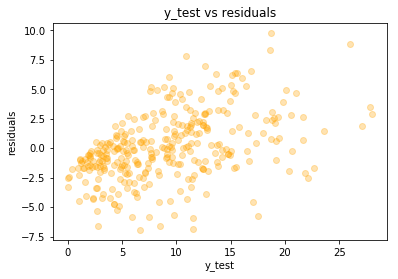

In [854]:
y_pred.reshape(-1,1)
plt.scatter(y_test.values,y_test.values-y_pred.reshape(-1,1),alpha=0.3, c='orange')
plt.title('y_test vs residuals')
plt.xlabel('y_test')
plt.ylabel('residuals')

In [864]:
scores=cross_validate(rf_reg,X=X_train,y=y_train,scoring='neg_mean_squared_error')
-scores['test_score'].mean()

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), wh

{'fit_time': array([0.26249599, 0.24164391, 0.24774122]),
 'score_time': array([0.00656629, 0.00697803, 0.00686288]),
 'test_score': array([ -7.9502373 , -10.21875038,  -9.37147824]),
 'train_score': array([-3.35993236, -2.81114714, -3.09379205])}

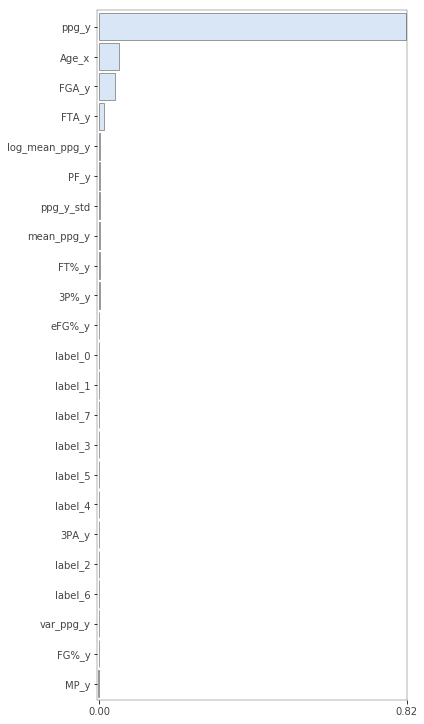

In [860]:
imp =importances(rf_reg, X_test, y_test) # permutation
viz = plot_importances(imp,width=6, vscale=2)
viz.view()

In [862]:
mean_squared_error(y_test,X_test['ppg_y'])

8.972459993683001

In [863]:
mean_squared_error(y_test,y_pred)

8.29411443974366

#  _______Try using all prev data as training data_______

In [927]:
def add_label2(dfi,year):
    
    df_train=dfi[dfi['Year_x']<year]
    mini_train=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
    X_cluster_train=df_train[['log_mean_ppg_y','ppg_y_std']]
    label_train=mini_train.fit_predict(X_cluster_train)

    df_train['label']=label_train
    df_train=pd.get_dummies(df_train,columns=['label'])
 

    df_year=dfi[dfi['Year_x']==year]
    mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
    X_cluster_test=df_year[['log_mean_ppg_y','ppg_y_std']]
    
    label_test=mini.fit_predict(X_cluster_test)
    df_year['label']=label_test
    df_year=pd.get_dummies(df_year,columns=['label'])
    
#     plt.scatter(X['log_mean_ppg_y'],X['ppg_y_std'], c=label_m,label='clusters')
#     plt.title('minibatch - 8 clusters, log mean ppg vs ppg std')
#     plt.xlabel('log mean ppg')
#     plt.ylabel('ppg std')
#     plt.legend()
#     plt.show()
    
    X_train=df_train[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
    y_train=df_train[['ppg_x']]
    X_test=df_year[['Age_x','ppg_y','mean_ppg_y','log_mean_ppg_y','var_ppg_y','ppg_y_std','MP_y','FG%_y','FGA_y','eFG%_y','FT%_y','FTA_y','3P%_y','3PA_y','PF_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6','label_7']]
    y_test=df_year[['ppg_x']]
    return (X_train,y_train,X_test,y_test,label_train,label_test)
    

In [928]:
X_train,y_train,X_test,y_test,label_train,label_test=add_label2(dfi,2012)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [933]:
type(label_train)

numpy.ndarray

In [929]:
rf_reg2 = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)
rf_reg2.fit(X_train,y_train)
y_pred2=rf_reg2.predict(X_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [934]:
type(y_pred)

numpy.ndarray

Text(0,0.5,'residuals')

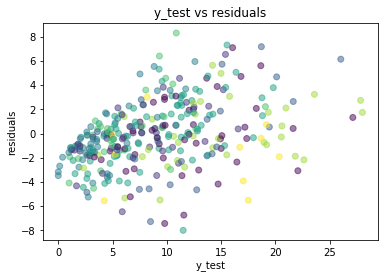

In [1069]:
y_pred.reshape(-1,1)
plt.scatter(y_test.values,y_test.values-y_pred2.reshape(-1,1),alpha=0.5, c=label_test.reshape(-1,1))
plt.title('y_test vs residuals')
plt.xlabel('y_test')
plt.ylabel('residuals')

In [931]:
mean_squared_error(y_test,X_test['ppg_y'])

8.972459993683001

In [932]:
mean_squared_error(y_test,y_pred)

8.29411443974366

# color map

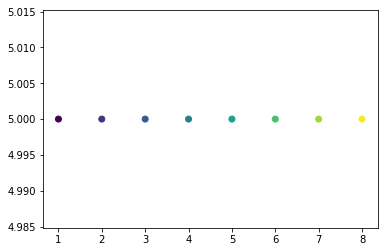

In [924]:
plt.scatter(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1),np.array([5,5,5,5,5,5,5,5]).reshape(-1,1), c=np.array([0,1,2,3,4,5,6,7]).reshape(-1,1))

In [1351]:
dfi['Year_x'].min()

2007

# Creating a class

In [2390]:
class ModelP:
    def __init__(self,year):
        self.year=year
        self.X_train=pd.DataFrame()
        self.y_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.y_test=pd.DataFrame()
        self.label_train=np.array([])
        self.label_test=np.array([])
        self.y_pred=np.array([])
        self.rf_reg=RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)    
           
        
    def fit(self,df): # creates clusters and sets up the data for the regression model
        df_train=df[df['Year_x']<self.year] 
    
        
        mini_train=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
        X_cluster_train=df_train[['log_mean_ppg_y','ppg_y_std']]
        
        self.label_train=mini_train.fit_predict(X_cluster_train)

        df_train['label']=self.label_train
        df_train=pd.get_dummies(df_train,columns=['label'])
 
        df_year=df[df['Year_x']==self.year]
        
        mini=MiniBatchKMeans(n_clusters=8, batch_size=100, random_state=4)
        
        X_cluster_test=df_year[['log_mean_ppg_y','ppg_y_std']]
    
        self.label_test=mini.fit_predict(X_cluster_test)
        df_year['label']=self.label_test
        df_year=pd.get_dummies(df_year,columns=['label'])

        self.X_train=df_train[['Age_x','ppg_y','log_mean_ppg_y','var_ppg_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6']]
        self.y_train=df_train[['ppg_x']]
        self.X_test=df_year[['Age_x','ppg_y','log_mean_ppg_y','var_ppg_y','label_0','label_1','label_2','label_3','label_4','label_5','label_6']]
        self.y_test=df_year[['ppg_x']]
            
    def predict(self,*args): # predicts the player ppg
        
        player_d={}
        self.rf_reg.fit(self.X_train,self.y_train)
        self.y_pred=self.rf_reg.predict(self.X_test)
        if not args:
            all_player=self.X_test.copy()
            all_player['ppg_pred']=self.y_pred.copy()
            all_player['label']=self.label_test.copy()
            all_player['true_ppg']=self.y_test.copy()
            
            return (all_player[['Age_x','ppg_y','ppg_pred','true_ppg','label']])
        else:
            for arg in args:
                player_pred=self.X_test.copy()
                player_pred['label']=self.label_test.copy()
                player_pred['ppg_pred']=self.y_pred.copy()
                player_d[arg]=player_pred[player_pred.index==arg+str(self.year)][['Age_x','ppg_y','ppg_pred','label']].copy()
                player_d[arg]['y_test']=self.y_test.copy()
                player_d[arg]=player_d[arg][['Age_x','ppg_y','ppg_pred','y_test','label']]
            return player_d
    
    def score(self): # returns the MSE score for the model and for the benchmark model
        mse=mean_squared_error(self.y_test,self.y_pred)
        print('The MSE is : {}'.format(mse))
        
        benchmark_error=mean_squared_error(self.y_test,self.X_test['ppg_y'])
        print('The benchmark MSE is : {}'.format(benchmark_error))
        return (mse)
        
    def plots(self,plot_type='residuals'): # plots --> plot_type= 'residuals' or 'hist'
        
        hand={}
        self.y_pred.reshape(-1,1)
        temp=pd.DataFrame(index=self.y_test.index, columns=['y_test','y_pred','cluster'])
        temp['y_test']=self.y_test
        temp['y_pred']=self.y_pred
        temp['cluster']=self.label_test
        cmap={0:'red',1:'orange', 2:'green', 3:'blue', 4:'magenta',5:'cyan',6:'black',7:'forestgreen'}
        if plot_type=='residuals':
            for element in temp['cluster'].unique():
                class_temp=temp[temp['cluster']==element]
                hand[element]=plt.scatter(class_temp['y_test'].values,class_temp['y_test'].values-class_temp['y_pred'].values,alpha=0.6, color=cmap[element],marker='.' ,label='clusters {}'.format(element))
            plt.title('y_test vs residuals')
            plt.xlabel('y_test')
            plt.ylabel('residuals')
            plt.legend((hand[0],hand[1],hand[2],hand[3],hand[4],hand[5],hand[6],hand[7]), ('cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7'))
            plt.show()
        elif plot_type=='hist':
            fig,axis = plt.subplots(2,4, figsize=(15,10))
            axis=axis.ravel()
            for element in temp['cluster'].unique():
                class_temp=temp[temp['cluster']==element]
                axis[element].hist(class_temp['y_test'].values-class_temp['y_pred'].values, bins=10, color='orange')
                axis[element].set_title('cluster {} residuals'.format(element))
                axis[element].set_xlabel('residuals')
                axis[element].set_ylabel('count')
            plt.tight_layout()
            plt.show()

    def clusters(self): # get the clusters with the residuals and player names
        cluster={}
        clus_resids={}
        c_temp=pd.DataFrame(index=self.y_test.index, columns=['y_test','y_pred','cluster'])
        c_temp['y_test']=self.y_test
        c_temp['y_pred']=self.y_pred
        c_temp['resids']=c_temp['y_test']-c_temp['y_pred']
        c_temp['cluster']=self.label_test
        for clus in c_temp['cluster'].unique():
            cluster[clus]=c_temp[c_temp['cluster']==clus]
            clus_resids[clus]=(cluster[clus]['resids'].mean(),cluster[clus]['resids'].std())
        return cluster, clus_resids
        
    def importance(self): # permutation feature importance using rfpimp library
        imp =importances(self.rf_reg, self.X_test, self.y_test) 
        viz = plot_importances(imp,width=6, vscale=2)
        viz.view()
        print(imp)

In [2384]:
model_opt=ModelP(2013)
model_opt.fit(dfi)
model_opt.predict('Ray Allen')

{'Ray Allen':                Age_x  ppg_y  ppg_pred  y_test  label
 Ray Allen2013   37.0  14.24     12.36   10.92      0}

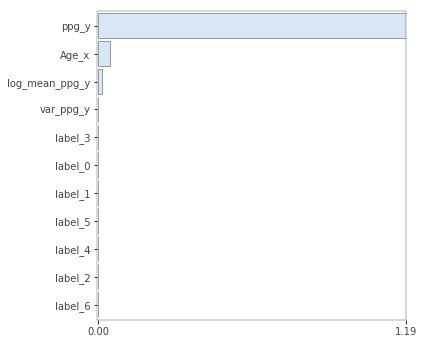

                Importance
Feature                   
ppg_y             1.18e+00
Age_x             4.48e-02
log_mean_ppg_y    1.67e-02
var_ppg_y         1.64e-03
label_3           9.75e-04
label_0           6.45e-04
label_1           1.04e-04
label_5           4.20e-05
label_4           7.72e-06
label_2           2.93e-06
label_6           0.00e+00


In [2386]:
model_opt.importance()

In [2388]:
score_optimum5=cross_val(dfi,10)

The MSE is : 9.275813989040454
The benchmark MSE is : 10.53196412029064
The MSE is : 8.82654996850968
The benchmark MSE is : 9.13363981371178
The MSE is : 8.029452216006819
The benchmark MSE is : 9.26076507629748
The MSE is : 8.239061356870906
The benchmark MSE is : 10.373275438983228
The MSE is : 7.455315939306534
The benchmark MSE is : 8.972459993683001
The MSE is : 8.742957323728952
The benchmark MSE is : 9.707826013127606
The MSE is : 9.96047786124497
The benchmark MSE is : 10.837581961235799
The MSE is : 7.857334724024443
The benchmark MSE is : 9.163776214407976
The MSE is : 9.433191184052113
The benchmark MSE is : 11.200234856506409
The MSE is : 8.9522684460399
The benchmark MSE is : 9.017923079175205


In [2389]:
np.mean(score_optimum5)

8.677242300882476

In [2382]:
score_optimum4=cross_val(dfi,10)

The MSE is : 9.244563930107583
The benchmark MSE is : 10.53196412029064
The MSE is : 8.85177143702003
The benchmark MSE is : 9.13363981371178
The MSE is : 8.071640011882193
The benchmark MSE is : 9.26076507629748
The MSE is : 8.277644586009027
The benchmark MSE is : 10.373275438983228
The MSE is : 7.4415583873073174
The benchmark MSE is : 8.972459993683001
The MSE is : 8.724338469747778
The benchmark MSE is : 9.707826013127606
The MSE is : 9.940756372652535
The benchmark MSE is : 10.837581961235799
The MSE is : 7.844813635178788
The benchmark MSE is : 9.163776214407976
The MSE is : 9.424435795824877
The benchmark MSE is : 11.200234856506409
The MSE is : 8.943036809405253
The benchmark MSE is : 9.017923079175205


In [2383]:
np.mean(score_optimum4)

8.676455943513538

In [2310]:
model_a=ModelP(2012)
model_a.fit(dfi)

In [2315]:
model_b=ModelP(2012)
model_b.fit(dfi)

In [2376]:
model_a2=ModelP(2012)
model_a2.fit(dfi)
model_a2.predict();


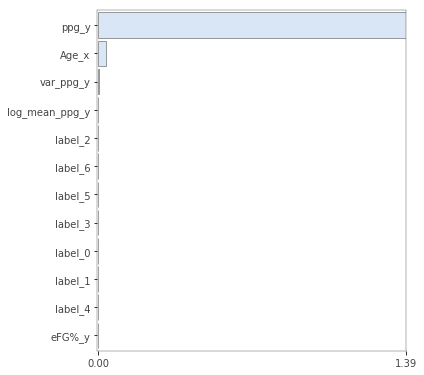

                Importance
Feature                   
ppg_y             1.39e+00
Age_x             3.42e-02
var_ppg_y         2.54e-03
log_mean_ppg_y    2.31e-03
label_2           1.76e-04
label_6           6.67e-05
label_5           1.70e-05
label_3           6.19e-06
label_0           0.00e+00
label_1          -8.71e-06
label_4          -1.27e-04
eFG%_y           -3.58e-04


In [2380]:
model_a2.importance()

In [2311]:
model_a.predict('Ray Allen' )

{'Ray Allen':                Age_x  ppg_y  ppg_pred  y_test  label
 Ray Allen2012   36.0  16.51     15.74   14.24      6}

In [2284]:
model_b.predict('Ray Allen')

{'Ray Allen':                Age_x  ppg_y  ppg_pred  y_test  label
 Ray Allen2012   36.0  16.51     15.69   14.24      6}

In [2348]:
score_a=cross_val(dfi,10)

The MSE is : 9.670394724887649
The benchmark MSE is : 10.53196412029064
The MSE is : 9.351734973444094
The benchmark MSE is : 9.13363981371178
The MSE is : 8.42260089037401
The benchmark MSE is : 9.26076507629748
The MSE is : 9.317752277546033
The benchmark MSE is : 10.373275438983228
The MSE is : 8.405308158428944
The benchmark MSE is : 8.972459993683001
The MSE is : 9.333170284765936
The benchmark MSE is : 9.707826013127606
The MSE is : 10.799425095778515
The benchmark MSE is : 10.837581961235799
The MSE is : 8.180789424109978
The benchmark MSE is : 9.163776214407976
The MSE is : 10.116092230211127
The benchmark MSE is : 11.200234856506409
The MSE is : 9.688112398115004
The benchmark MSE is : 9.017923079175205


In [2349]:
np.mean(score_a)

9.328538045766129

In [2342]:
score_a2=cross_val(dfi,10)

The MSE is : 9.915615688904726
The benchmark MSE is : 10.53196412029064
The MSE is : 8.93405946953736
The benchmark MSE is : 9.13363981371178
The MSE is : 8.549385938649829
The benchmark MSE is : 9.26076507629748
The MSE is : 8.483883391428288
The benchmark MSE is : 10.373275438983228
The MSE is : 7.5599294974861415
The benchmark MSE is : 8.972459993683001
The MSE is : 8.823882816032084
The benchmark MSE is : 9.707826013127606
The MSE is : 10.132425080701493
The benchmark MSE is : 10.837581961235799
The MSE is : 7.981467123236495
The benchmark MSE is : 9.163776214407976
The MSE is : 9.35620667939142
The benchmark MSE is : 11.200234856506409
The MSE is : 9.18097809488739
The benchmark MSE is : 9.017923079175205


In [2343]:
np.mean(score_a2)

8.891783378025522

In [2316]:
score_b=cross_val(dfi,10)

The MSE is : 9.873622783499343
The benchmark MSE is : 10.53196412029064
The MSE is : 9.416896571116046
The benchmark MSE is : 9.13363981371178
The MSE is : 8.445019818218947
The benchmark MSE is : 9.26076507629748
The MSE is : 9.307285130634186
The benchmark MSE is : 10.373275438983228
The MSE is : 8.35226777380425
The benchmark MSE is : 8.972459993683001
The MSE is : 9.244231565148713
The benchmark MSE is : 9.707826013127606
The MSE is : 10.82181361401892
The benchmark MSE is : 10.837581961235799
The MSE is : 8.171052324872946
The benchmark MSE is : 9.163776214407976
The MSE is : 10.149316756567307
The benchmark MSE is : 11.200234856506409
The MSE is : 9.69188649184407
The benchmark MSE is : 9.017923079175205


In [2317]:
np.mean(score_b)

9.347339282972474

In [2271]:
score_c=cross_val(dfi,10)

The MSE is : 13.113148968861855
The benchmark MSE is : 10.53196412029064
The MSE is : 9.156013307603853
The benchmark MSE is : 9.13363981371178
The MSE is : 8.554017094164388
The benchmark MSE is : 9.26076507629748
The MSE is : 8.803394407929694
The benchmark MSE is : 10.373275438983228
The MSE is : 7.642215121713319
The benchmark MSE is : 8.972459993683001
The MSE is : 8.768475378496746
The benchmark MSE is : 9.707826013127606
The MSE is : 10.069708835593534
The benchmark MSE is : 10.837581961235799
The MSE is : 7.802215363604262
The benchmark MSE is : 9.163776214407976
The MSE is : 9.327336677365595
The benchmark MSE is : 11.200234856506409
The MSE is : 9.084410380006448
The benchmark MSE is : 9.017923079175205


In [2272]:
np.mean(score_c)

9.232093553533968

In [ ]:
8.772356581950492

In [2255]:
model_a=ModelP(2012)
model_a.fit(dfi)

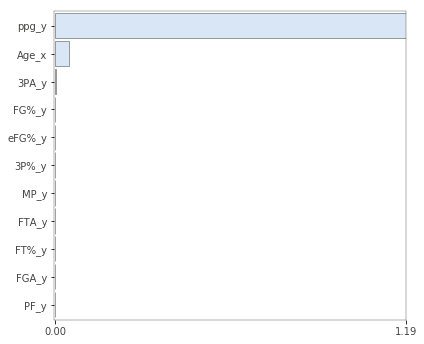

         Importance
Feature            
ppg_y      1.19e+00
Age_x      4.81e-02
3PA_y      1.92e-03
FG%_y      1.51e-03
eFG%_y     1.02e-03
3P%_y      6.76e-04
MP_y       3.91e-04
FTA_y      1.74e-04
FT%_y      1.56e-05
FGA_y     -2.35e-04
PF_y      -1.13e-03


In [2259]:
model_a.importance()

In [2398]:
temp=dfi[['ppg_y_std','log_mean_ppg_y']]

ppg_y_std  log_mean_ppg_y
Shareef Abdur-Rahim2007       3.19            2.68
Malik Allen2007               0.33            1.64
Ray Allen2007                 0.80            3.20
Tony Allen2007                0.60            1.92
Rafer Alston2007              1.50            2.58
Derek Anderson2007            0.76            2.16
Carmelo Anthony2007           4.07            3.16
Rafael Araujo2007             0.70            1.04
Gilbert Arenas2007            2.72            3.31
Trevor Ariza2007              0.86            1.66
Darrell Armstrong2007         1.35            1.11
Carlos Arroyo2007             0.53            1.83
Chucky Atkins2007             2.86            2.45
Marcus Banks2007              3.80            1.99
Leandro Barbosa2007           4.27            2.31
Matt Barnes2007               0.49            1.24
Andre Barrett2007             1.04            1.35
Brent Barry2007               1.13            1.89
Tony Battie2007               2.16            1.85
Shane Battier2007             0.14            2.30
Raja Bell2007                 1.74            2.60
Mike Bibby2007                1.02            3.01
Andris Biedrins2007           0.11            1.31
Chauncey Billups2007          1.42            2.86
Steve Blake2007               2.75            1.84
Mark Blount2007               1.33            2.34
Keith Bogans2007              0.71            2.21
Matt Bonner2007               0.21            1.99
Calvin Booth2007              0.73            0.65
Carlos Boozer2007             1.10            2.84
...                            ...             ...
Beno Udrih2017                3.55            2.09
Jonas Valanciunas2017         1.67            2.42
Anderson Varejao2017          3.08            2.07
Greivis Vasquez2017           3.57            2.14
Noah Vonleh2017               0.22            1.25
Nikola Vucevic2017            5.42            2.64
Sasha Vujacic2017             2.63            1.62
Dwyane Wade2017               3.52            3.18
Dion Waiters2017              2.78            2.57
Kemba Walker2017              3.15            2.84
John Wall2017                 1.49            2.89
T.J. Warren2017               3.42            2.14
C.J. Watson2017               2.62            1.99
David West2017                4.98            2.73
Russell Westbrook2017         4.18            3.08
Hassan Whiteside2017          7.14            1.93
Andrew Wiggins2017            2.66            2.93
C.J. Wilcox2017               0.77            0.92
Deron Williams2017            3.35            2.82
Derrick Williams2017          1.57            2.23
Lou Williams2017              4.56            2.46
Marvin Williams2017           2.54            2.36
Jeff Withey2017               0.81            1.22
Metta World2017               6.66            2.60
Brandan Wright2017            1.97            1.92
James Young2017               1.69            0.79
Nick Young2017                4.00            2.48
Thaddeus Young2017            2.62            2.63
Cody Zeller2017               1.39            2.01
Tyler Zeller2017              2.04            2.01

[3535 rows x 2 columns]

In [2057]:
#dfi2=pd.read_csv('data/Season_Featurized.csv')

In [2054]:
model=ModelP(2012)

In [2011]:
model.score()

The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


7.4674771986233734

In [1968]:
model2=ModelP(2012)

In [1969]:
model2.fit(dfi)

In [1981]:
# model3=ModelP(2012)
# model3.fit(dfi)
# model3.model_predict()

model3.score()

The MSE is : 7.7341826742084905
The benchmark MSE is : 8.972459993683001


7.7341826742084905

In [2062]:
model4=ModelP(2012)
model4.fit(dfi)
model4.model_predict()

model4.score()

The MSE is : 7.412246151728247
The benchmark MSE is : 8.972459993683001


7.412246151728247

In [2051]:
y_pred2=model2.model_predict()

In [1972]:
model2.score()


The MSE is : 7.496689236391482
The benchmark MSE is : 8.972459993683001


7.496689236391482

In [1963]:
model.fit(dfi)

In [1964]:
y_pred=model.model_predict()

In [1965]:
y_pred

Age_x  ppg_y  ppg_pred  true_ppg  label
Arron Afflalo2012       26.0  12.57     11.59     15.21      1
LaMarcus Aldridge2012   26.0  21.84     19.01     21.65      2
Ray Allen2012           36.0  16.51     15.41     14.24      6
Tony Allen2012          30.0   8.93      6.97      9.79      0
Lou Amundson2012        29.0   4.35      4.19      3.55      3
Chris Andersen2012      33.0   5.56      4.37      5.25      3
Ryan Anderson2012       23.0  10.64      8.97     16.07      0
Carmelo Anthony2012     27.0  25.58     24.80     22.64      6
Joel Anthony2012        29.0   2.04      2.38      3.42      5
Gilbert Arenas2012      30.0  10.79      9.79      4.24      7
Trevor Ariza2012        26.0  11.01     10.15     10.83      1
D.J. Augustin2012       24.0  14.37     13.54     11.08      1
Renaldo Balkman2012     27.0   2.00      2.43      3.00      3
Leandro Barbosa2012     29.0  13.26     11.80     11.06      6
J.J. Barea2012          27.0   9.49      8.32     11.29      4
Andrea Bargnani2012     26.0  21.42     18.92     19.45      2
Matt Barnes2012         31.0   6.72      5.40      7.79      4
Earl Barron2012         30.0   3.76      3.45      2.00      1
Brandon Bass2012        26.0  11.24     10.33     12.51      1
Tony Battie2012         35.0   2.63      2.61      1.56      3
Shane Battier2012       33.0   7.61      6.24      4.78      0
Nicolas Batum2012       23.0  12.38     11.61     13.86      1
Jerryd Bayless2012      23.0   9.17      9.06     11.39      4
Michael Beasley2012     23.0  19.19     19.50     11.51      4
Rodrigue Beaubois2012   23.0   8.43      8.52      8.91      5
Marco Belinelli2012     25.0  10.45      9.24     11.82      1
Raja Bell2012           35.0   7.96      6.61      6.38      4
Mike Bibby2012          33.0   8.60      7.50      2.64      2
Andris Biedrins2012     25.0   4.98      6.00      1.68      1
Chauncey Billups2012    35.0  16.78     15.39     14.95      0
...                      ...    ...       ...       ...    ...
Dwyane Wade2012         30.0  25.54     25.15     22.08      0
Von Wafer2012           26.0   3.17      4.33      5.88      1
Henry Walker2012        24.0   4.89      6.35      5.91      1
Ben Wallace2012         37.0   2.85      3.59      1.37      4
Gerald Wallace2012      29.0  15.68     15.58     13.79      4
Luke Walton2012         31.0   1.69      2.70      1.83      1
Hakim Warrick2012       29.0   8.36      7.65      6.43      4
C.J. Watson2012         27.0   4.94      5.85      9.67      1
Earl Watson2012         32.0   4.29      4.50      2.98      4
Martell Webster2012     25.0   9.85      8.90      6.89      1
David West2012          31.0  18.89     17.40     12.76      2
Delonte West2012        28.0   5.62      5.26      9.57      4
Russell Westbrook2012   23.0  21.87     20.37     23.61      6
D.J. White2012          25.0   5.70      6.18      6.76      3
Chris Wilcox2012        29.0   7.44      6.78      5.43      1
Damien Wilkins2012      32.0   3.46      3.66      3.22      3
Deron Williams2012      27.0  20.14     18.87     20.98      6
Lou Williams2012        25.0  13.69     13.08     14.94      2
Marvin Williams2012     25.0  10.40     10.41     10.16      4
Mo Williams2012         29.0  14.00     12.49     13.17      4
Reggie Williams2012     25.0   9.22      9.62      8.30      6
Shawne Williams2012     25.0   7.09      7.84      4.52      3
Shelden Williams2012    28.0   4.47      4.49      4.62      5
Terrence Williams2012   24.0   5.05      6.14      7.10      4
Metta World2012         32.0   8.50      7.66      7.70      2
Brandan Wright2012      24.0   3.81      4.85      6.94      4
Dorell Wright2012       26.0  16.39     14.54     10.31      2
Nick Young2012          26.0  17.42     15.85     14.18      2
Sam Young2012           26.0   7.33      7.78      3.26      5
Thaddeus Young2012      23.0  12.74     12.62     12.83      4

[324 rows x 5 columns]

In [2049]:
model.score()

The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


7.4674771986233734

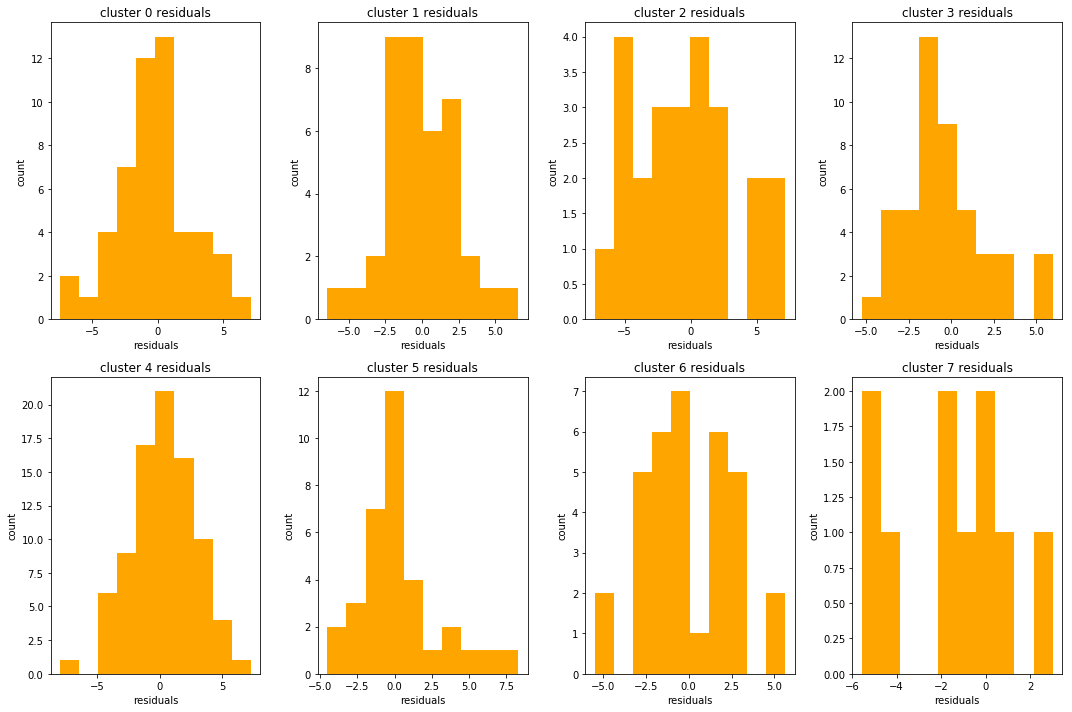

In [1954]:
model.plots(plot_type='hist')

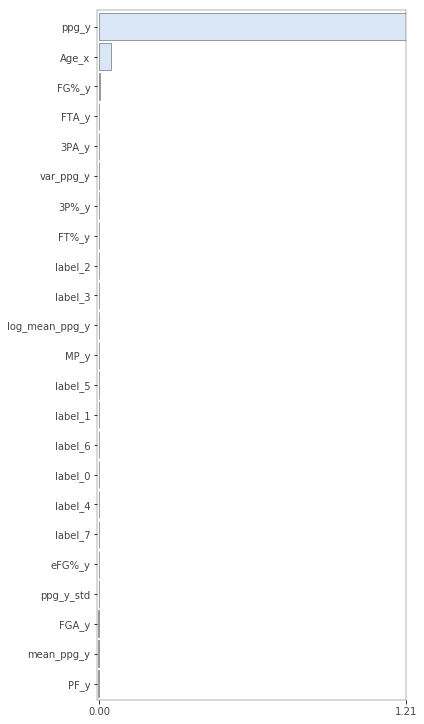

                Importance
Feature                   
ppg_y             1.20e+00
Age_x             4.59e-02
FG%_y             3.00e-03
FTA_y             1.67e-03
3PA_y             1.66e-03
var_ppg_y         5.35e-04
3P%_y             3.22e-04
FT%_y             2.26e-04
label_2           1.59e-04
label_3           1.37e-04
log_mean_ppg_y    8.17e-05
MP_y              7.88e-05
label_5           6.89e-05
label_1           4.15e-05
label_6           0.00e+00
label_0           0.00e+00
label_4          -3.76e-05
label_7          -4.08e-05
eFG%_y           -7.97e-04
ppg_y_std        -8.79e-04
FGA_y            -1.52e-03
mean_ppg_y       -1.74e-03
PF_y             -3.60e-03


In [1955]:
model.importance()

In [1956]:
y_pred['Ray Allen']

Age_x  ppg_y  ppg_pred  y_test  label
Ray Allen2012   36.0  16.51     15.41   14.24      6

y_pred.sort_values('Age_x')

In [1600]:
y_pred[y_pred.index=='Arron Afflalo2012']

Age_x  ppg_y  mean_ppg_y  log_mean_ppg_y  var_ppg_y  \
Arron Afflalo2012   26.0  12.57        7.49            2.01      16.25   

                   ppg_y_std    MP_y  FG%_y  FGA_y  eFG%_y  FT%_y  FTA_y  \
Arron Afflalo2012       4.03  2324.0    0.5  627.0    0.58   0.85  163.0   

                   3P%_y  3PA_y   PF_y  label_0  label_1  label_2  label_3  \
Arron Afflalo2012   0.42  248.0  153.0        0        1        0        0   

                   label_4  label_5  label_6  label_7  
Arron Afflalo2012        0        0        0        0

In [1894]:
model.score()

The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


7.4674771986233734

In [1898]:
player_clus, res=model.clusters()

In [1899]:
res

{1: (-0.09806734690593452, 2.5198311156557867),
 2: (-0.4022574112893061, 3.8767937323121218),
 6: (-0.04849974865305144, 2.6061957553242125),
 0: (-0.209533068295408, 2.8550763613111645),
 3: (-0.3301808493459036, 2.456100003894372),
 5: (0.282209112656463, 2.7219470503219854),
 7: (-1.6545794352747976, 2.7244337468204733),
 4: (0.19343279517569822, 2.598134925092597)}

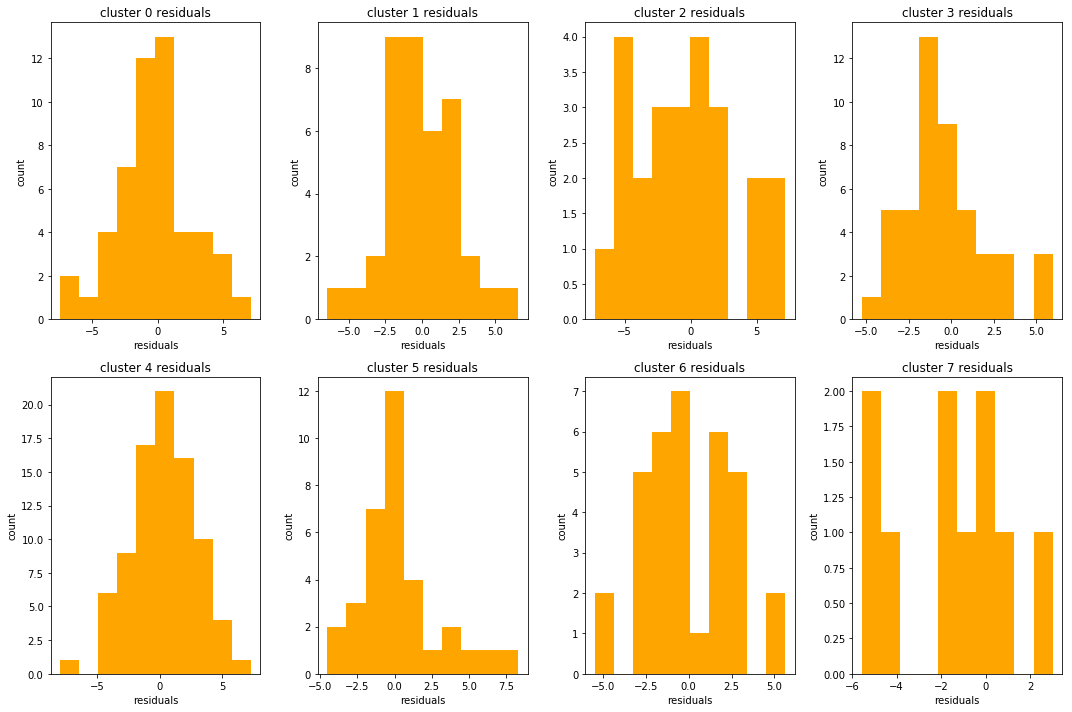

In [1796]:
model.plots(plot_type='hist')

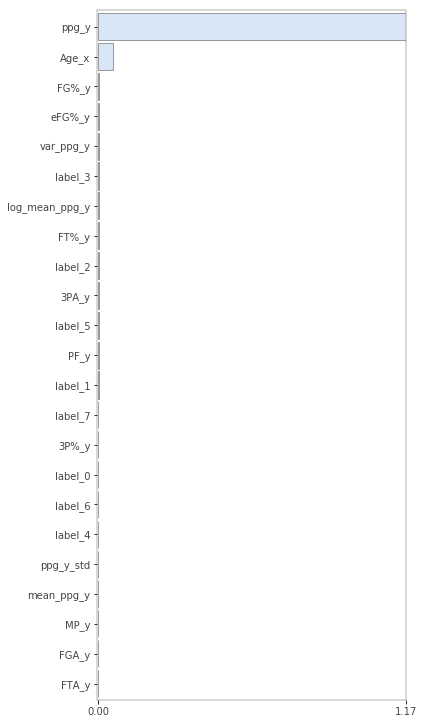

                Importance
Feature                   
ppg_y             1.17e+00
Age_x             5.62e-02
FG%_y             1.28e-03
eFG%_y            1.10e-03
var_ppg_y         8.38e-04
label_3           6.29e-04
log_mean_ppg_y    5.70e-04
FT%_y             5.21e-04
label_2           4.04e-04
3PA_y             2.47e-04
label_5           1.20e-04
PF_y              8.31e-05
label_1           6.14e-05
label_7           1.23e-05
3P%_y             8.70e-06
label_0           0.00e+00
label_6           0.00e+00
label_4          -5.84e-05
ppg_y_std        -1.75e-04
mean_ppg_y       -1.09e-03
MP_y             -1.35e-03
FGA_y            -1.64e-03
FTA_y            -1.95e-03


In [1804]:
model.importance()

In [2263]:
def cross_val(df,number=5):
    score=[]
    for element in range(number):
        cross_model=ModelP(2008+element)  
        cross_model.fit(df)
        y_pred=cross_model.predict()
        score.append(cross_model.score())
    return (score) 

In [1974]:
scores=cross_val(dfi)

The MSE is : 8.699700444248496
The benchmark MSE is : 10.53196412029064
The MSE is : 8.640034644898755
The benchmark MSE is : 9.13363981371178
The MSE is : 7.768613016050529
The benchmark MSE is : 9.26076507629748
The MSE is : 8.278681419907091
The benchmark MSE is : 10.373275438983228
The MSE is : 7.496689236391482
The benchmark MSE is : 8.972459993683001


In [1415]:
scores

[9.602701133445807,
 8.726737962515688,
 8.383274339098229,
 8.438594631086993,
 7.4674771986233734]

In [1414]:
np.sqrt(np.mean(scores))

2.9195474054986703

In [2048]:
scores2=cross_val(dfi)

The MSE is : 9.630967217429278
The benchmark MSE is : 10.53196412029064
The MSE is : 8.840881013025944
The benchmark MSE is : 9.13363981371178
The MSE is : 8.31549328528487
The benchmark MSE is : 9.26076507629748
The MSE is : 8.46764327070607
The benchmark MSE is : 10.373275438983228
The MSE is : 7.472252708463971
The benchmark MSE is : 8.972459993683001


In [1423]:
np.log(10)

2.302585092994046

In [1717]:
#TOY
abc=pd.DataFrame(index=[0,1,2], columns=['a','b','c'], data=[[1,2,3],[4,5,6],[7,8,9,]])

In [1718]:
abc

a  b  c
0  1  2  3
1  4  5  6
2  7  8  9

In [1731]:
index=abc['a']

In [1732]:
cba=abc.set_index(index)

In [1733]:
cba

a  b  c
a         
1  1  2  3
4  4  5  6
7  7  8  9

In [1742]:
abc=pd.read_csv('data/Season_Featurized.csv',index_col=[0])


In [1973]:
abc;


# Grid Search

In [2000]:
param_grid={'learning_rate':[0.1,0.5,1,2],'n_estimators':[50,100,200],'max_depth':[1,3,5]}

In [2001]:
gs=GridSearchCV(GradientBoostingRegressor(),param_grid, scoring='neg_mean_squared_error')

In [2002]:
gs.fit(model3.X_train,model3.y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.5, 1, 2], 'n_estimators': [50, 100, 200], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [2003]:
y4_pred=gs.predict(model3.X_test)

In [2008]:
mean_squared_error(model3.y_test,y4_pred)

7.68238547610433

In [2012]:
gs.get_params();

In [2005]:
dss=pd.DataFrame(gs.cv_results_)

In [2013]:
gs.best_estimator_;

In [2034]:
param_grid4={'n_estimators':[100,200,300],'max_depth':[5,7,9]}

In [2035]:
gs4=GridSearchCV(RandomForestRegressor(),param_grid2, scoring='neg_mean_squared_error')

In [2036]:
gs4.fit(model3.X_train,model3.y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [2037]:
gs4.best_estimator_


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [2045]:
mean_squared_error(gs2.predict(model3.X_test), model3.y_test)

7.480655201598951

In [2046]:
gs2.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [2071]:
model=ModelP(2012)

In [2072]:
model.fit(dfi)

In [2075]:
model.model_predict();

In [2076]:
model.score()

The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


7.4674771986233734

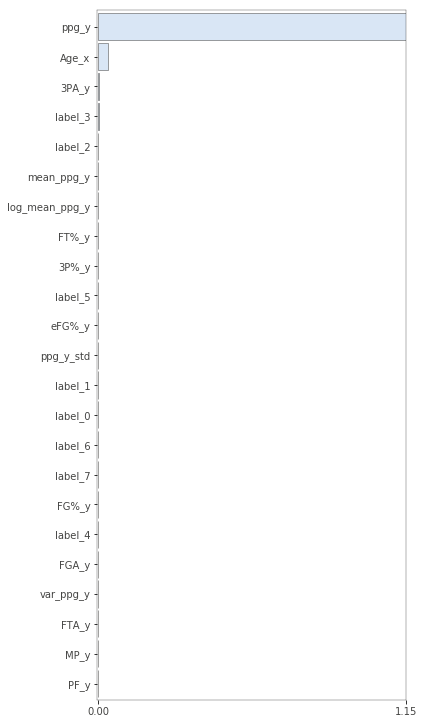

                Importance
Feature                   
ppg_y             1.14e+00
Age_x             3.51e-02
3PA_y             1.02e-03
label_3           6.63e-04
label_2           5.05e-04
mean_ppg_y        3.02e-04
log_mean_ppg_y    2.78e-04
FT%_y             2.14e-04
3P%_y             1.64e-04
label_5           1.40e-04
eFG%_y            7.23e-05
ppg_y_std         5.10e-05
label_1           1.63e-05
label_0           0.00e+00
label_6           0.00e+00
label_7          -5.06e-06
FG%_y            -1.86e-05
label_4          -2.07e-05
FGA_y            -8.57e-04
var_ppg_y        -1.03e-03
FTA_y            -1.14e-03
MP_y             -1.20e-03
PF_y             -1.31e-03


In [2078]:
model.importance()

In [2079]:
dfi

Year_x team_x               Player  ppg_x  ppm_x  \
Shareef Abdur-Rahim2007    2007    SAC  Shareef Abdur-Rahim   9.91   0.39   
Malik Allen2007            2007    CHI          Malik Allen   4.03   0.38   
Ray Allen2007              2007    SEA            Ray Allen  26.44   0.66   
Tony Allen2007             2007    BOS           Tony Allen  11.48   0.47   
Rafer Alston2007           2007    HOU         Rafer Alston  13.27   0.36   
Derek Anderson2007         2007    CHA       Derek Anderson   7.98   0.34   
Carmelo Anthony2007        2007    DEN      Carmelo Anthony  28.94   0.76   
Rafael Araujo2007          2007    UTA        Rafael Araujo   2.57   0.29   
Gilbert Arenas2007         2007    WAS       Gilbert Arenas  28.45   0.72   
Trevor Ariza2007           2007    ORL         Trevor Ariza   8.88   0.40   
Darrell Armstrong2007      2007    IND    Darrell Armstrong   5.64   0.36   
Carlos Arroyo2007          2007    ORL        Carlos Arroyo   7.67   0.42   
Chucky Atkins2007          2007    MEM        Chucky Atkins  13.17   0.48   
Marcus Banks2007           2007    PHO         Marcus Banks   4.91   0.44   
Leandro Barbosa2007        2007    PHO      Leandro Barbosa  18.05   0.55   
Matt Barnes2007            2007    GSW          Matt Barnes   9.82   0.41   
Andre Barrett2007          2007    CHI        Andre Barrett   1.33   0.28   
Brent Barry2007            2007    SAS          Brent Barry   8.47   0.39   
Tony Battie2007            2007    ORL          Tony Battie   6.12   0.26   
Shane Battier2007          2007    HOU        Shane Battier  10.11   0.28   
Raja Bell2007              2007    PHO            Raja Bell  14.65   0.39   
Mike Bibby2007             2007    SAC           Mike Bibby  17.11   0.50   
Andris Biedrins2007        2007    GSW      Andris Biedrins   9.55   0.33   
Chauncey Billups2007       2007    DET     Chauncey Billups  17.01   0.47   
Steve Blake2007            2007    DEN          Steve Blake   6.44   0.24   
Mark Blount2007            2007    MIN          Mark Blount  12.32   0.40   
Keith Bogans2007           2007    ORL         Keith Bogans   5.05   0.30   
Matt Bonner2007            2007    SAS          Matt Bonner   4.91   0.42   
Calvin Booth2007           2007    WAS         Calvin Booth   1.57   0.18   
Carlos Boozer2007          2007    UTA        Carlos Boozer  20.93   0.61   
...                         ...    ...                  ...    ...    ...   
Beno Udrih2017             2017    DET           Beno Udrih   5.82   0.41   
Jonas Valanciunas2017      2017    TOR    Jonas Valanciunas  11.99   0.46   
Anderson Varejao2017       2017    GSW     Anderson Varejao   1.29   0.20   
Greivis Vasquez2017        2017    BRK      Greivis Vasquez   2.33   0.18   
Noah Vonleh2017            2017    POR          Noah Vonleh   4.42   0.26   
Nikola Vucevic2017         2017    ORL       Nikola Vucevic  14.61   0.51   
Sasha Vujacic2017          2017    NYK        Sasha Vujacic   2.95   0.30   
Dwyane Wade2017            2017    CHI          Dwyane Wade  18.27   0.61   
Dion Waiters2017           2017    MIA         Dion Waiters  15.85   0.53   
Kemba Walker2017           2017    CHO         Kemba Walker  23.16   0.67   
John Wall2017              2017    WAS            John Wall  23.14   0.64   
T.J. Warren2017            2017    PHO          T.J. Warren  14.41   0.46   
C.J. Watson2017            2017    ORL          C.J. Watson   4.53   0.28   
David West2017             2017    GSW           David West   4.65   0.37   
Russell Westbrook2017      2017    OKC    Russell Westbrook  31.58   0.91   
Hassan Whiteside2017       2017    MIA     Hassan Whiteside  17.00   0.52   
Andrew Wiggins2017         2017    MIN       Andrew Wiggins  23.57   0.63   
C.J. Wilcox2017            2017    ORL          C.J. Wilcox   0.95   0.19   
Deron Williams2017         2017    DAL       Deron Williams  10.95   0.42   
Derrick Williams2017       2017    MIA     Derrick Williams   6.08   0.38   
Lou Williams2017     

# remove features and test position.

In [2086]:
cross_val(dfi,5)

The MSE is : 9.602701133445807
The benchmark MSE is : 10.53196412029064
The MSE is : 8.726737962515688
The benchmark MSE is : 9.13363981371178
The MSE is : 8.383274339098229
The benchmark MSE is : 9.26076507629748
The MSE is : 8.438594631086993
The benchmark MSE is : 10.373275438983228
The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


[9.602701133445807,
 8.726737962515688,
 8.383274339098229,
 8.438594631086993,
 7.4674771986233734]

In [2088]:
cross_val(dfi,5)

The MSE is : 9.589377305362845
The benchmark MSE is : 10.53196412029064
The MSE is : 8.889350366487196
The benchmark MSE is : 9.13363981371178
The MSE is : 8.226376436248943
The benchmark MSE is : 9.26076507629748
The MSE is : 8.360445854785574
The benchmark MSE is : 10.373275438983228
The MSE is : 7.424330834287581
The benchmark MSE is : 8.972459993683001


[9.589377305362845,
 8.889350366487196,
 8.226376436248943,
 8.360445854785574,
 7.424330834287581]

In [2091]:
model_f=ModelP(2012)
model_f.fit(dfi)
model_f.model_predict()
model_f.score()

The MSE is : 7.424330834287581
The benchmark MSE is : 8.972459993683001


7.424330834287581

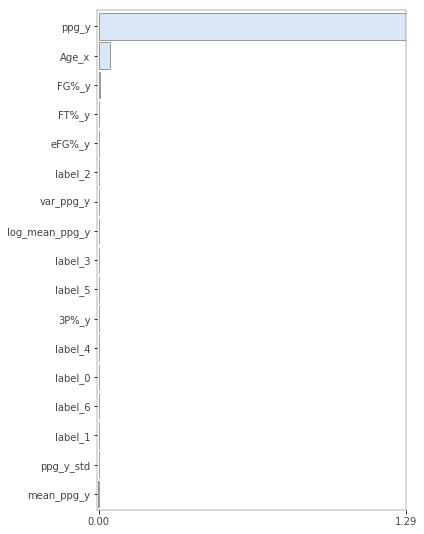

                Importance
Feature                   
ppg_y             1.29e+00
Age_x             4.52e-02
FG%_y             5.97e-03
FT%_y             9.47e-04
eFG%_y            9.08e-04
label_2           5.04e-04
var_ppg_y         4.13e-04
log_mean_ppg_y    3.79e-04
label_3           3.65e-04
label_5           4.46e-05
3P%_y             4.26e-05
label_4           1.09e-05
label_0           0.00e+00
label_6           0.00e+00
label_1          -8.34e-06
ppg_y_std        -1.26e-04
mean_ppg_y       -3.76e-03


In [2096]:
model_f.importance()

In [2095]:
dfi[['mean_ppg_y','ppg_y']]

mean_ppg_y  ppg_y
Shareef Abdur-Rahim2007       14.58  12.32
Malik Allen2007                5.16   4.93
Ray Allen2007                 24.50  25.06
Tony Allen2007                 6.81   7.24
Rafer Alston2007              13.14  12.08
Derek Anderson2007             8.65   8.12
Carmelo Anthony2007           23.65  26.52
Rafael Araujo2007              2.82   2.33
Gilbert Arenas2007            27.40  29.32
Trevor Ariza2007               5.24   4.63
Darrell Armstrong2007          3.05   2.10
Carlos Arroyo2007              6.21   5.83
Chucky Atkins2007             11.57   9.55
Marcus Banks2007               7.28   9.97
Leandro Barbosa2007           10.03  13.05
Matt Barnes2007                3.47   3.12
Andre Barrett2007              3.84   4.58
Brent Barry2007                6.62   5.82
Tony Battie2007                6.39   7.91
Shane Battier2007             10.00  10.10
Raja Bell2007                 13.48  14.71
Mike Bibby2007                20.36  21.07
Andris Biedrins2007            3.71   3.79
Chauncey Billups2007          17.45  18.46
Steve Blake2007                6.29   8.24
Mark Blount2007               10.34  11.28
Keith Bogans2007               9.14   8.64
Matt Bonner2007                7.33   7.47
Calvin Booth2007               1.91   1.39
Carlos Boozer2007             17.05  16.27
...                             ...    ...
Beno Udrih2017                 8.11   4.66
Jonas Valanciunas2017         11.27  12.80
Anderson Varejao2017           7.91   2.60
Greivis Vasquez2017            8.51   5.65
Noah Vonleh2017                3.47   3.63
Nikola Vucevic2017            14.07  18.17
Sasha Vujacic2017              5.06   4.85
Dwyane Wade2017               24.03  19.04
Dion Waiters2017              13.02   9.77
Kemba Walker2017              17.14  20.85
John Wall2017                 17.99  19.88
T.J. Warren2017                8.54  10.96
C.J. Watson2017                7.30   4.30
David West2017                15.30   7.10
Russell Westbrook2017         21.69  23.48
Hassan Whiteside2017           6.90  14.25
Andrew Wiggins2017            18.80  20.68
C.J. Wilcox2017                2.50   3.04
Deron Williams2017            16.86  14.12
Derrick Williams2017           9.29   9.32
Lou Williams2017              11.69  15.34
Marvin Williams2017           10.59  11.70
Jeff Withey2017                3.39   4.25
Metta World2017               13.45   5.03
Brandan Wright2017             6.84   6.92
James Young2017                2.19   1.00
Nick Young2017                11.98   7.26
Thaddeus Young2017            13.87  15.10
Cody Zeller2017                7.44   8.74
Tyler Zeller2017               7.46   6.07

[3535 rows x 2 columns]

In [2098]:
model_f2=ModelP(2012)
model_f2.fit(dfi)
model_f2.model_predict()
model_f2.score()

The MSE is : 7.438046304226104
The benchmark MSE is : 8.972459993683001


7.438046304226104

In [2099]:
cross_val(dfi,5)

The MSE is : 9.565513256483367
The benchmark MSE is : 10.53196412029064
The MSE is : 8.886364822858207
The benchmark MSE is : 9.13363981371178
The MSE is : 8.225146128261546
The benchmark MSE is : 9.26076507629748
The MSE is : 8.355836486323524
The benchmark MSE is : 10.373275438983228
The MSE is : 7.438046304226104
The benchmark MSE is : 8.972459993683001


[9.565513256483367,
 8.886364822858207,
 8.225146128261546,
 8.355836486323524,
 7.438046304226104]

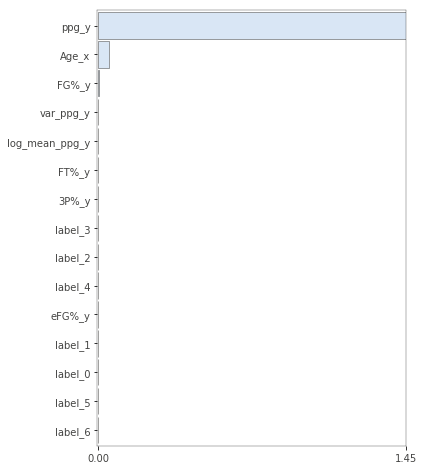

                Importance
Feature                   
ppg_y             1.45e+00
Age_x             5.00e-02
FG%_y             4.53e-03
var_ppg_y         2.49e-03
log_mean_ppg_y    2.28e-03
FT%_y             7.35e-04
3P%_y             5.37e-04
label_3           2.24e-04
label_2           2.19e-04
label_4           1.42e-04
eFG%_y            5.93e-05
label_1           2.72e-05
label_0           0.00e+00
label_5          -2.71e-05
label_6          -2.73e-05


In [2100]:
model_f2.importance()

In [2104]:
dfi.columns.values

array(['Year_x', 'team_x', 'Player', 'ppg_x', 'ppm_x', 'mean_ppg_x',
       'var_ppg_x', 'PTS_x', 'Pos_x', 'Age_x', 'G_x', 'GS_x', 'MP_x',
       'PER_x', 'TS%_x', '3PAr_x', 'FTr_x', 'ORB%_x', 'DRB%_x', 'TRB%_x',
       'AST%_x', 'STL%_x', 'BLK%_x', 'TOV%_x', 'USG%_x', 'OWS_x', 'DWS_x',
       'WS_x', 'WS/48_x', 'OBPM_x', 'DBPM_x', 'BPM_x', 'VORP_x', 'FG_x',
       'FGA_x', 'FG%_x', '3P_x', '3PA_x', '3P%_x', '2P_x', '2PA_x',
       '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x', 'ORB_x', 'DRB_x',
       'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'prev_year_x',
       'Year_y', 'team_y', 'ppg_y', 'ppm_y', 'mean_ppg_y', 'var_ppg_y',
       'PTS_y', 'Pos_y', 'Age_y', 'G_y', 'GS_y', 'MP_y', 'PER_y', 'TS%_y',
       '3PAr_y', 'FTr_y', 'ORB%_y', 'DRB%_y', 'TRB%_y', 'AST%_y',
       'STL%_y', 'BLK%_y', 'TOV%_y', 'USG%_y', 'OWS_y', 'DWS_y', 'WS_y',
       'WS/48_y', 'OBPM_y', 'DBPM_y', 'BPM_y', 'VORP_y', 'FG_y', 'FGA_y',
       'FG%_y', '3P_y', '3PA_y', '3P%_y', '2P_y', '2PA_y', '2P%_y'

In [2148]:
model_f3=ModelP(2012)

In [2149]:
model_f3.fit(dfi2)

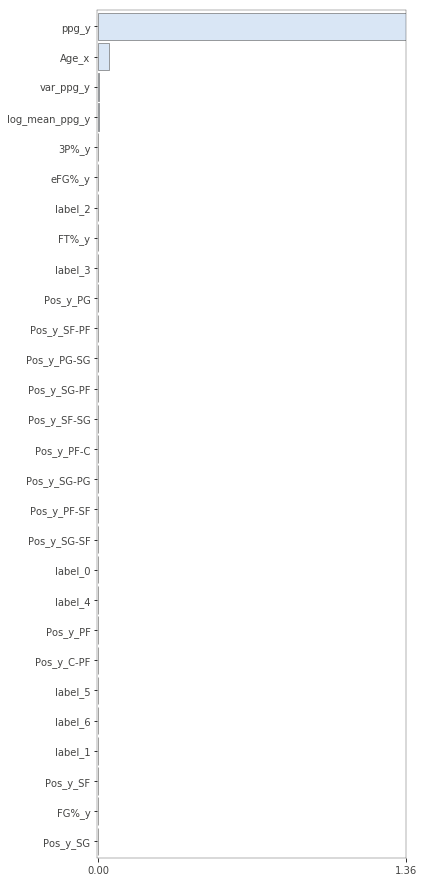

                Importance
Feature                   
ppg_y             1.36e+00
Age_x             4.73e-02
var_ppg_y         4.59e-03
log_mean_ppg_y    3.32e-03
3P%_y             1.60e-03
eFG%_y            6.70e-04
label_2           3.99e-04
FT%_y             2.97e-04
label_3           2.92e-04
Pos_y_PG          7.00e-06
Pos_y_SF-PF       0.00e+00
Pos_y_PG-SG       0.00e+00
Pos_y_SG-PF       0.00e+00
Pos_y_SF-SG       0.00e+00
Pos_y_PF-C        0.00e+00
Pos_y_SG-PG       0.00e+00
Pos_y_PF-SF       0.00e+00
Pos_y_SG-SF       0.00e+00
label_0           0.00e+00
label_4          -9.62e-06
Pos_y_PF         -1.32e-05
Pos_y_C-PF       -1.60e-05
label_5          -2.61e-05
label_6          -4.22e-05
label_1          -4.91e-05
Pos_y_SF         -5.16e-05
FG%_y            -9.72e-05
Pos_y_SG         -2.37e-04


In [2153]:
model_f3.importance()

In [2152]:
cross_val(dfi2,5)

The MSE is : 9.57294281164325
The benchmark MSE is : 10.53196412029064
The MSE is : 8.907428875407248
The benchmark MSE is : 9.13363981371178
The MSE is : 8.191575050427394
The benchmark MSE is : 9.26076507629748
The MSE is : 8.386460272278466
The benchmark MSE is : 10.373275438983228
The MSE is : 7.438820477416516
The benchmark MSE is : 8.972459993683001


[9.57294281164325,
 8.907428875407248,
 8.191575050427394,
 8.386460272278466,
 7.438820477416516]

In [2136]:
dfi2=dfi.copy()

In [2139]:
dfi2=pd.get_dummies(dfi2,columns=['Pos_y'],drop_first=True)

In [2140]:
dfi2.columns.values

array(['Year_x', 'team_x', 'Player', 'ppg_x', 'ppm_x', 'mean_ppg_x',
       'var_ppg_x', 'PTS_x', 'Pos_x', 'Age_x', 'G_x', 'GS_x', 'MP_x',
       'PER_x', 'TS%_x', '3PAr_x', 'FTr_x', 'ORB%_x', 'DRB%_x', 'TRB%_x',
       'AST%_x', 'STL%_x', 'BLK%_x', 'TOV%_x', 'USG%_x', 'OWS_x', 'DWS_x',
       'WS_x', 'WS/48_x', 'OBPM_x', 'DBPM_x', 'BPM_x', 'VORP_x', 'FG_x',
       'FGA_x', 'FG%_x', '3P_x', '3PA_x', '3P%_x', '2P_x', '2PA_x',
       '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x', 'ORB_x', 'DRB_x',
       'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'prev_year_x',
       'Year_y', 'team_y', 'ppg_y', 'ppm_y', 'mean_ppg_y', 'var_ppg_y',
       'PTS_y', 'Age_y', 'G_y', 'GS_y', 'MP_y', 'PER_y', 'TS%_y',
       '3PAr_y', 'FTr_y', 'ORB%_y', 'DRB%_y', 'TRB%_y', 'AST%_y',
       'STL%_y', 'BLK%_y', 'TOV%_y', 'USG%_y', 'OWS_y', 'DWS_y', 'WS_y',
       'WS/48_y', 'OBPM_y', 'DBPM_y', 'BPM_y', 'VORP_y', 'FG_y', 'FGA_y',
       'FG%_y', '3P_y', '3PA_y', '3P%_y', '2P_y', '2PA_y', '2P%_y',
       

In [2158]:
y_pred['diff']=y_pred['true_ppg']-y_pred['ppg_y']

In [2160]:
y_pred['diff2']=y_pred['true_ppg']-y_pred['ppg_pred']

In [2165]:
y_pred['big']=np.abs(y_pred['diff'])>np.abs(y_pred['diff2'])

In [2171]:
y_pred['big'].sum()

187

In [2172]:
324-187

137

In [2173]:
187/324

0.5771604938271605

In [2180]:
# model_a=ModelP(2012)
# model_a.fit(dfi)
model_a.model_predict();

In [2181]:
model_a.score()

The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001


7.4674771986233734

In [2182]:
cross_val(dfi,7)

The MSE is : 9.602701133445807
The benchmark MSE is : 10.53196412029064
The MSE is : 8.726737962515688
The benchmark MSE is : 9.13363981371178
The MSE is : 8.383274339098229
The benchmark MSE is : 9.26076507629748
The MSE is : 8.438594631086993
The benchmark MSE is : 10.373275438983228
The MSE is : 7.4674771986233734
The benchmark MSE is : 8.972459993683001
The MSE is : 8.65368993607291
The benchmark MSE is : 9.707826013127606
The MSE is : 10.075944087122497
The benchmark MSE is : 10.837581961235799


[9.602701133445807,
 8.726737962515688,
 8.383274339098229,
 8.438594631086993,
 7.4674771986233734,
 8.65368993607291,
 10.075944087122497]

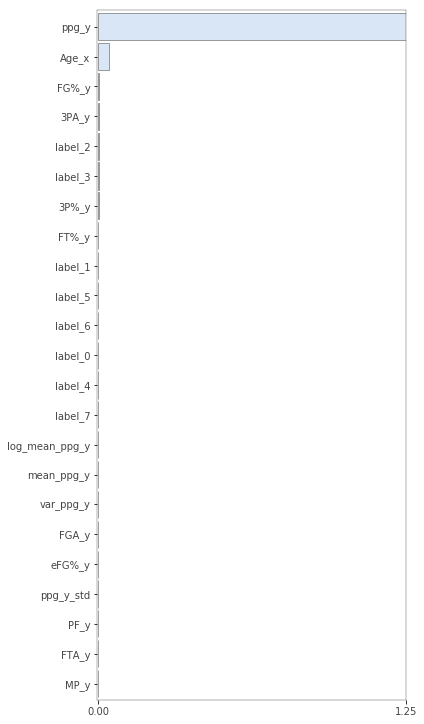

                Importance
Feature                   
ppg_y             1.24e+00
Age_x             4.15e-02
FG%_y             1.99e-03
3PA_y             9.72e-04
label_2           7.70e-04
label_3           4.49e-04
3P%_y             3.88e-04
FT%_y             2.06e-04
label_1           4.56e-05
label_5           2.33e-05
label_6           3.81e-06
label_0           0.00e+00
label_4          -2.14e-05
label_7          -5.08e-04
log_mean_ppg_y   -6.09e-04
mean_ppg_y       -6.89e-04
var_ppg_y        -8.54e-04
FGA_y            -1.08e-03
eFG%_y           -1.32e-03
ppg_y_std        -1.35e-03
PF_y             -1.49e-03
FTA_y            -1.50e-03
MP_y             -2.03e-03


In [2183]:
model_a.importance()

In [2187]:
model_b=ModelP(2012)

In [2188]:
model_b.fit(dfi)

In [2189]:
model_b.model_predict();

In [2190]:
model_b.score()

The MSE is : 7.424330834287581
The benchmark MSE is : 8.972459993683001


7.424330834287581

In [2191]:
cross_val(dfi,7)

The MSE is : 9.589377305362845
The benchmark MSE is : 10.53196412029064
The MSE is : 8.889350366487196
The benchmark MSE is : 9.13363981371178
The MSE is : 8.226376436248943
The benchmark MSE is : 9.26076507629748
The MSE is : 8.360445854785574
The benchmark MSE is : 10.373275438983228
The MSE is : 7.424330834287581
The benchmark MSE is : 8.972459993683001
The MSE is : 8.750496968010246
The benchmark MSE is : 9.707826013127606
The MSE is : 10.005759633392199
The benchmark MSE is : 10.837581961235799


[9.589377305362845,
 8.889350366487196,
 8.226376436248943,
 8.360445854785574,
 7.424330834287581,
 8.750496968010246,
 10.005759633392199]

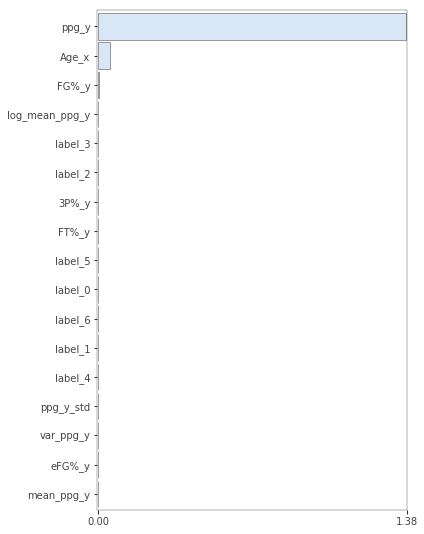

                Importance
Feature                   
ppg_y             1.38e+00
Age_x             5.03e-02
FG%_y             2.38e-03
log_mean_ppg_y    7.24e-04
label_3           6.24e-04
label_2           4.79e-04
3P%_y             3.21e-04
FT%_y             2.06e-04
label_5           1.41e-04
label_0           0.00e+00
label_6           0.00e+00
label_1          -1.86e-05
label_4          -5.44e-05
ppg_y_std        -1.37e-04
var_ppg_y        -3.83e-04
eFG%_y           -4.74e-04
mean_ppg_y       -1.76e-03


In [2192]:
model_b.importance()

In [2194]:
model_c=ModelP(2012)

In [2196]:
model_c.fit(dfi)

In [2198]:
model_c.model_predict();

In [2199]:
model_c.score()

The MSE is : 7.438046304226104
The benchmark MSE is : 8.972459993683001


7.438046304226104

In [2204]:
scores=cross_val(dfi,7)

The MSE is : 9.565513256483367
The benchmark MSE is : 10.53196412029064
The MSE is : 8.886364822858207
The benchmark MSE is : 9.13363981371178
The MSE is : 8.225146128261546
The benchmark MSE is : 9.26076507629748
The MSE is : 8.355836486323524
The benchmark MSE is : 10.373275438983228
The MSE is : 7.438046304226104
The benchmark MSE is : 8.972459993683001
The MSE is : 8.747208207585286
The benchmark MSE is : 9.707826013127606
The MSE is : 10.002348582826722
The benchmark MSE is : 10.837581961235799


In [ ]:
The MSE is : 9.589377305362845
The benchmark MSE is : 10.53196412029064
The MSE is : 8.889350366487196
The benchmark MSE is : 9.13363981371178
The MSE is : 8.226376436248943
The benchmark MSE is : 9.26076507629748
The MSE is : 8.360445854785574
The benchmark MSE is : 10.373275438983228
The MSE is : 7.424330834287581
The benchmark MSE is : 8.972459993683001
The MSE is : 8.750496968010246
The benchmark MSE is : 9.707826013127606
The MSE is : 10.005759633392199
The benchmark MSE is : 10.837581961235799

In [2203]:
(9.589377305362845+8.889350366487196+8.226376436248943+8.360445854785574+7.424330834287581+8.750496968010246+10.005759633392199)/7

8.74944819979637

In [2206]:
np.mean(scores)

8.745780541223537

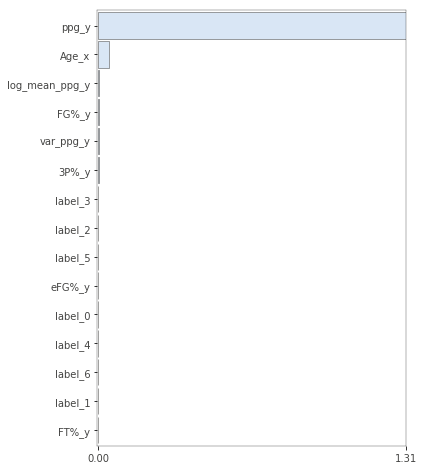

                Importance
Feature                   
ppg_y             1.31e+00
Age_x             4.69e-02
log_mean_ppg_y    3.07e-03
FG%_y             1.98e-03
var_ppg_y         1.43e-03
3P%_y             9.82e-04
label_3           5.46e-04
label_2           4.86e-04
label_5           1.56e-04
eFG%_y            1.30e-04
label_0           0.00e+00
label_4          -3.11e-05
label_6          -4.65e-05
label_1          -1.21e-04
FT%_y            -1.84e-03


In [2208]:
model_c.importance()

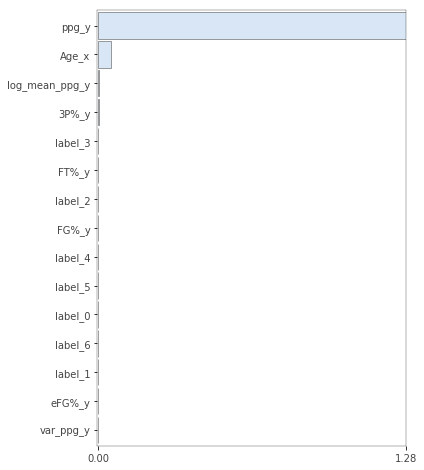

                Importance
Feature                   
ppg_y             1.28e+00
Age_x             5.25e-02
log_mean_ppg_y    3.09e-03
3P%_y             1.11e-03
label_3           9.69e-04
FT%_y             5.20e-04
label_2           3.78e-04
FG%_y             1.55e-04
label_4           8.35e-05
label_5           7.69e-05
label_0           0.00e+00
label_6          -6.10e-06
label_1          -1.69e-05
eFG%_y           -2.45e-04
var_ppg_y        -1.25e-03


In [2209]:
model_c.importance()

In [2215]:
model_d=ModelP(2012)

In [2216]:
model_d.fit(dfi)

In [2217]:
model_d.model_predict()

Age_x  ppg_y  ppg_pred  true_ppg  label
Arron Afflalo2012       26.0  12.57     10.98     15.21      1
LaMarcus Aldridge2012   26.0  21.84     18.69     21.65      2
Ray Allen2012           36.0  16.51     15.80     14.24      6
Tony Allen2012          30.0   8.93      7.15      9.79      0
Lou Amundson2012        29.0   4.35      3.47      3.55      3
Chris Andersen2012      33.0   5.56      3.85      5.25      3
Ryan Anderson2012       23.0  10.64     10.55     16.07      0
Carmelo Anthony2012     27.0  25.58     23.39     22.64      6
Joel Anthony2012        29.0   2.04      2.29      3.42      5
Gilbert Arenas2012      30.0  10.79      7.18      4.24      7
Trevor Ariza2012        26.0  11.01      8.27     10.83      1
D.J. Augustin2012       24.0  14.37     13.59     11.08      1
Renaldo Balkman2012     27.0   2.00      2.61      3.00      3
Leandro Barbosa2012     29.0  13.26     11.11     11.06      6
J.J. Barea2012          27.0   9.49      8.62     11.29      4
Andrea Bargnani2012     26.0  21.42     17.76     19.45      2
Matt Barnes2012         31.0   6.72      5.91      7.79      4
Earl Barron2012         30.0   3.76      2.99      2.00      1
Brandon Bass2012        26.0  11.24      9.62     12.51      1
Tony Battie2012         35.0   2.63      2.57      1.56      3
Shane Battier2012       33.0   7.61      6.39      4.78      0
Nicolas Batum2012       23.0  12.38     10.47     13.86      1
Jerryd Bayless2012      23.0   9.17      9.15     11.39      4
Michael Beasley2012     23.0  19.19     18.37     11.51      4
Rodrigue Beaubois2012   23.0   8.43      8.99      8.91      5
Marco Belinelli2012     25.0  10.45     10.69     11.82      1
Raja Bell2012           35.0   7.96      7.49      6.38      4
Mike Bibby2012          33.0   8.60      7.58      2.64      2
Andris Biedrins2012     25.0   4.98      5.96      1.68      1
Chauncey Billups2012    35.0  16.78     14.80     14.95      0
...                      ...    ...       ...       ...    ...
Dwyane Wade2012         30.0  25.54     24.71     22.08      0
Von Wafer2012           26.0   3.17      4.62      5.88      1
Henry Walker2012        24.0   4.89      6.04      5.91      1
Ben Wallace2012         37.0   2.85      2.66      1.37      4
Gerald Wallace2012      29.0  15.68     15.07     13.79      4
Luke Walton2012         31.0   1.69      2.78      1.83      1
Hakim Warrick2012       29.0   8.36      7.94      6.43      4
C.J. Watson2012         27.0   4.94      4.51      9.67      1
Earl Watson2012         32.0   4.29      3.61      2.98      4
Martell Webster2012     25.0   9.85     10.07      6.89      1
David West2012          31.0  18.89     17.20     12.76      2
Delonte West2012        28.0   5.62      5.09      9.57      4
Russell Westbrook2012   23.0  21.87     18.52     23.61      6
D.J. White2012          25.0   5.70      6.29      6.76      3
Chris Wilcox2012        29.0   7.44      7.41      5.43      1
Damien Wilkins2012      32.0   3.46      3.77      3.22      3
Deron Williams2012      27.0  20.14     16.92     20.98      6
Lou Williams2012        25.0  13.69      9.89     14.94      2
Marvin Williams2012     25.0  10.40     10.06     10.16      4
Mo Williams2012         29.0  14.00     13.46     13.17      4
Reggie Williams2012     25.0   9.22     10.13      8.30      6
Shawne Williams2012     25.0   7.09     10.47      4.52      3
Shelden Williams2012    28.0   4.47      4.48      4.62      5
Terrence Williams2012   24.0   5.05      5.52      7.10      4
Metta World2012         32.0   8.50      6.79      7.70      2
Brandan Wright2012      24.0   3.81      5.13      6.94      4
Dorell Wright2012       26.0  16.39     14.42     10.31      2
Nick Young2012          26.0  17.42     14.39     14.18      2
Sam Young2012           26.0   7.33      6.83      3.26      5
Thaddeus Young2012      23.0  12.74     11.28     12.83      4

[324 rows x 5 columns]

In [2218]:
model_d.score()

The MSE is : 8.011250719618744
The benchmark MSE is : 8.972459993683001


8.011250719618744

In [2219]:
score_d=cross_val(dfi,7)

The MSE is : 9.565513256483367
The benchmark MSE is : 10.53196412029064
The MSE is : 9.121915508943566
The benchmark MSE is : 9.13363981371178
The MSE is : 8.751094034078957
The benchmark MSE is : 9.26076507629748
The MSE is : 9.478598763039312
The benchmark MSE is : 10.373275438983228
The MSE is : 8.011250719618744
The benchmark MSE is : 8.972459993683001
The MSE is : 9.083933213602478
The benchmark MSE is : 9.707826013127606
The MSE is : 11.165107534415194
The benchmark MSE is : 10.837581961235799


In [2221]:
np.mean(score_d)

9.31105900431166

In [2223]:
model_e=ModelP(2012)

In [2224]:
model_e.fit(dfi)

In [2226]:
model_e.score()

The MSE is : 7.441077531905396
The benchmark MSE is : 8.972459993683001


7.441077531905396

In [2228]:
score_e=cross_val(dfi,7)

The MSE is : 9.574077941710648
The benchmark MSE is : 10.53196412029064
The MSE is : 8.869980476730998
The benchmark MSE is : 9.13363981371178
The MSE is : 8.202397914637746
The benchmark MSE is : 9.26076507629748
The MSE is : 8.349863526861743
The benchmark MSE is : 10.373275438983228
The MSE is : 7.441077531905396
The benchmark MSE is : 8.972459993683001
The MSE is : 8.759916271939463
The benchmark MSE is : 9.707826013127606
The MSE is : 10.02635738576566
The benchmark MSE is : 10.837581961235799


In [2229]:
np.mean(score_e)

8.746238721364522

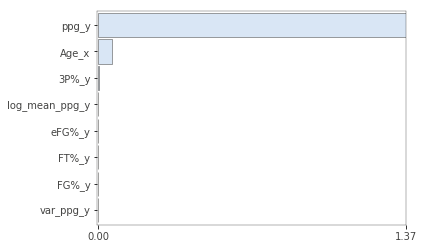

                Importance
Feature                   
ppg_y             1.37e+00
Age_x             6.20e-02
3P%_y             1.96e-03
log_mean_ppg_y    1.10e-03
eFG%_y            7.30e-04
FT%_y             4.41e-04
FG%_y             5.14e-05
var_ppg_y        -1.41e-03


In [2232]:
model_e.importance()

In [2233]:
model_c.score()

The MSE is : 7.438046304226104
The benchmark MSE is : 8.972459993683001


7.438046304226104

In [2235]:
score_e=cross_val(dfi,10)

The MSE is : 9.574077941710648
The benchmark MSE is : 10.53196412029064
The MSE is : 8.869980476730998
The benchmark MSE is : 9.13363981371178
The MSE is : 8.202397914637746
The benchmark MSE is : 9.26076507629748
The MSE is : 8.349863526861743
The benchmark MSE is : 10.373275438983228
The MSE is : 7.441077531905396
The benchmark MSE is : 8.972459993683001
The MSE is : 8.759916271939463
The benchmark MSE is : 9.707826013127606
The MSE is : 10.02635738576566
The benchmark MSE is : 10.837581961235799
The MSE is : 7.896517669099927
The benchmark MSE is : 9.163776214407976
The MSE is : 9.41924769543628
The benchmark MSE is : 11.200234856506409
The MSE is : 8.943389444255773
The benchmark MSE is : 9.017923079175205


In [2243]:
round(np.mean(score_e),4)

8.7483

In [2245]:
10.53196412029064+9.13363981371178+9.26076507629748+10.373275438983228+8.972459993683001+9.707826013127606+10.837581961235799+9.163776214407976+11.200234856506409+9.017923079175205

98.19944656741913

In [2240]:
np.mean(score_e)

8.748282585834364

In [2246]:
98.19944656741913/10

9.819944656741914